In [275]:
import os
os.chdir('/Users/beth/Documents/Metis/metis_project_2/metis_project2')
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


### Exploring the data

Import the dataframe scraped from Discogs.com and Spotify.com

In [276]:
with open('final_record_1000_manual_update.pickle', 'rb') as read_file:
    df = pickle.load(read_file)

There are some null values, but only 2 nulls for the target value category (Median price).
Lowest price and highest price will be ignored.

In [277]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   artists                    1000 non-null   object
 1   albums                     1000 non-null   object
 2   artist_links               1000 non-null   object
 3   album_links                1000 non-null   object
 4   release_year               997 non-null    object
 5   label                      1000 non-null   object
 6   release_country            999 non-null    object
 7   total_artist_albums        989 non-null    object
 8   artist_last_years          989 non-null    object
 9   artist_first_years         989 non-null    object
 10  first_release_links        1000 non-null   object
 11  number_of_songs            1000 non-null   int64 
 12  average_song_length        794 non-null    object
 13  index                      1000 non-null   int64 
 14  users_hav

I need to convert a lot of these columns to numbers, and since NaN values can't be converted to integers, but can be convert to floats, I converted the values to floats

In [278]:
df['release_year'] = df['release_year'].astype('float')
df['total_artist_albums'] = df['total_artist_albums'].astype('float')
df['artist_last_years'] = df['artist_last_years'].astype('float')
df['artist_first_years'] = df['artist_first_years'].astype('float')
df['number_of_songs'] = df['number_of_songs'].astype('float')
df['users_have'] = df['users_have'].astype('float')
df['users_want'] = df['users_want'].astype('float')
df['user_rating'] = df['user_rating'].astype('float')
df['versions'] = df['versions'].astype('float')
df['spotify_monthly_listeners'] = df['spotify_monthly_listeners'].astype('float')

df['median_price'] = df['median_price'].str.replace(',','')
df['median_price'] = df['median_price'].astype('float')

df['number_for_sale'] = df['number_for_sale'].str.replace(',','')
df['number_for_sale'] = df['number_for_sale'].astype('float')

df.drop('highest_price', axis=1, inplace=True)
df.drop('lowest_price', axis=1, inplace=True)

### Creating new variables based on year or time differences

I changed some of the date and time columns to datetime objects, and I calculated some differences between times as new variables. For example, years_after_first_album represents the number of years the album of interest was released after the artist's first album was. I dropped columns that would be highly correlated with these new columns.

In [279]:
#the time since last sold as a number of days
df['last_sold'] = pd.to_datetime(df['last_sold'])
df['time_since_sold'] = datetime.today()-df['last_sold']
df = df.drop('last_sold', axis=1)
df['time_since_sold'] = df['time_since_sold'].dt.days

#the number of years the album was released after the artist's first album was 
#(measure of how established the artist was)
df['years_after_first_album']=df['release_year']-df['artist_first_years']
df=df.drop('artist_first_years',axis=1)

#the number of years since any album containing that artist's material was produced
#(measure of the relevance of the artist today)
df['years_since_any_album']=2020-df['artist_last_years']
df=df.drop('artist_last_years', axis=1)

#the number of years it has been since the album was released
df['years_since_release']=2020-df['release_year']
df=df.drop('release_year', axis=1)

#the average song length in minutes as a decimal float number
df['average_song_length'] = pd.to_datetime(df['average_song_length'])
df['average_song_length'] = df['average_song_length'].dt.hour + df['average_song_length'].dt.minute/60

I also dropped the link columns

In [280]:
df.drop(['artist_links', 'album_links', 'first_release_links'], axis=1, inplace=True)

In [281]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   artists                    1000 non-null   object 
 1   albums                     1000 non-null   object 
 2   label                      1000 non-null   object 
 3   release_country            999 non-null    object 
 4   total_artist_albums        989 non-null    float64
 5   number_of_songs            1000 non-null   float64
 6   average_song_length        794 non-null    float64
 7   index                      1000 non-null   int64  
 8   users_have                 1000 non-null   float64
 9   users_want                 1000 non-null   float64
 10  user_rating                1000 non-null   float64
 11  median_price               978 non-null    float64
 12  styles                     1000 non-null   object 
 13  genres                     1000 non-null   object

### Looking at the distribution of the target variable (median price)

I looked at a histogram of my target variable 'median_price' and saw it was pretty skewed toward 0, and had a few very high outliers. I thought that transforming my target variable (predicting it thought a transformation link function) would be a good idea. I tried both the inverse (1/x) and the log (log(x)) of my target, and in a standard linear model using all of the data, the log of 'median_price' had a better R^2, meaning that the variables could predict the log 

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


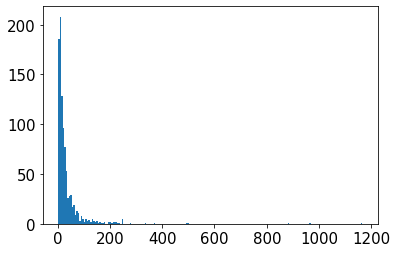

In [282]:
plt.hist(df['median_price'],bins=200);
#the warning is due to 2 np.nan values

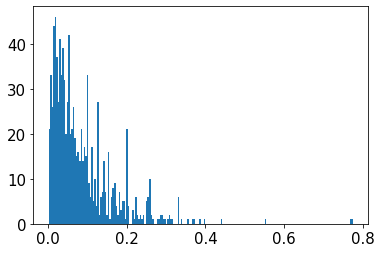

In [283]:
plt.hist(1/df['median_price'],bins=200);

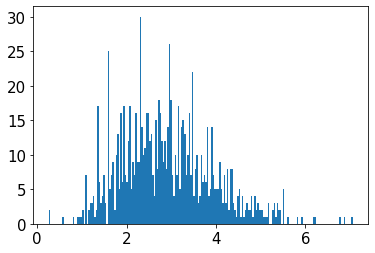

In [284]:
plt.hist(np.log(df['median_price']),bins=200);

I looked at the Pearson correlation between the continous variables in my dataframe, and added the log and inverse of median_price, to see if the correlations were better with either of these targets

In [285]:
df['log_median_price']=np.log(df['median_price'])
df['inv_median_price']=1/df['median_price']

### Plotting Pearson correlations between the predictors, target, and transformed targets

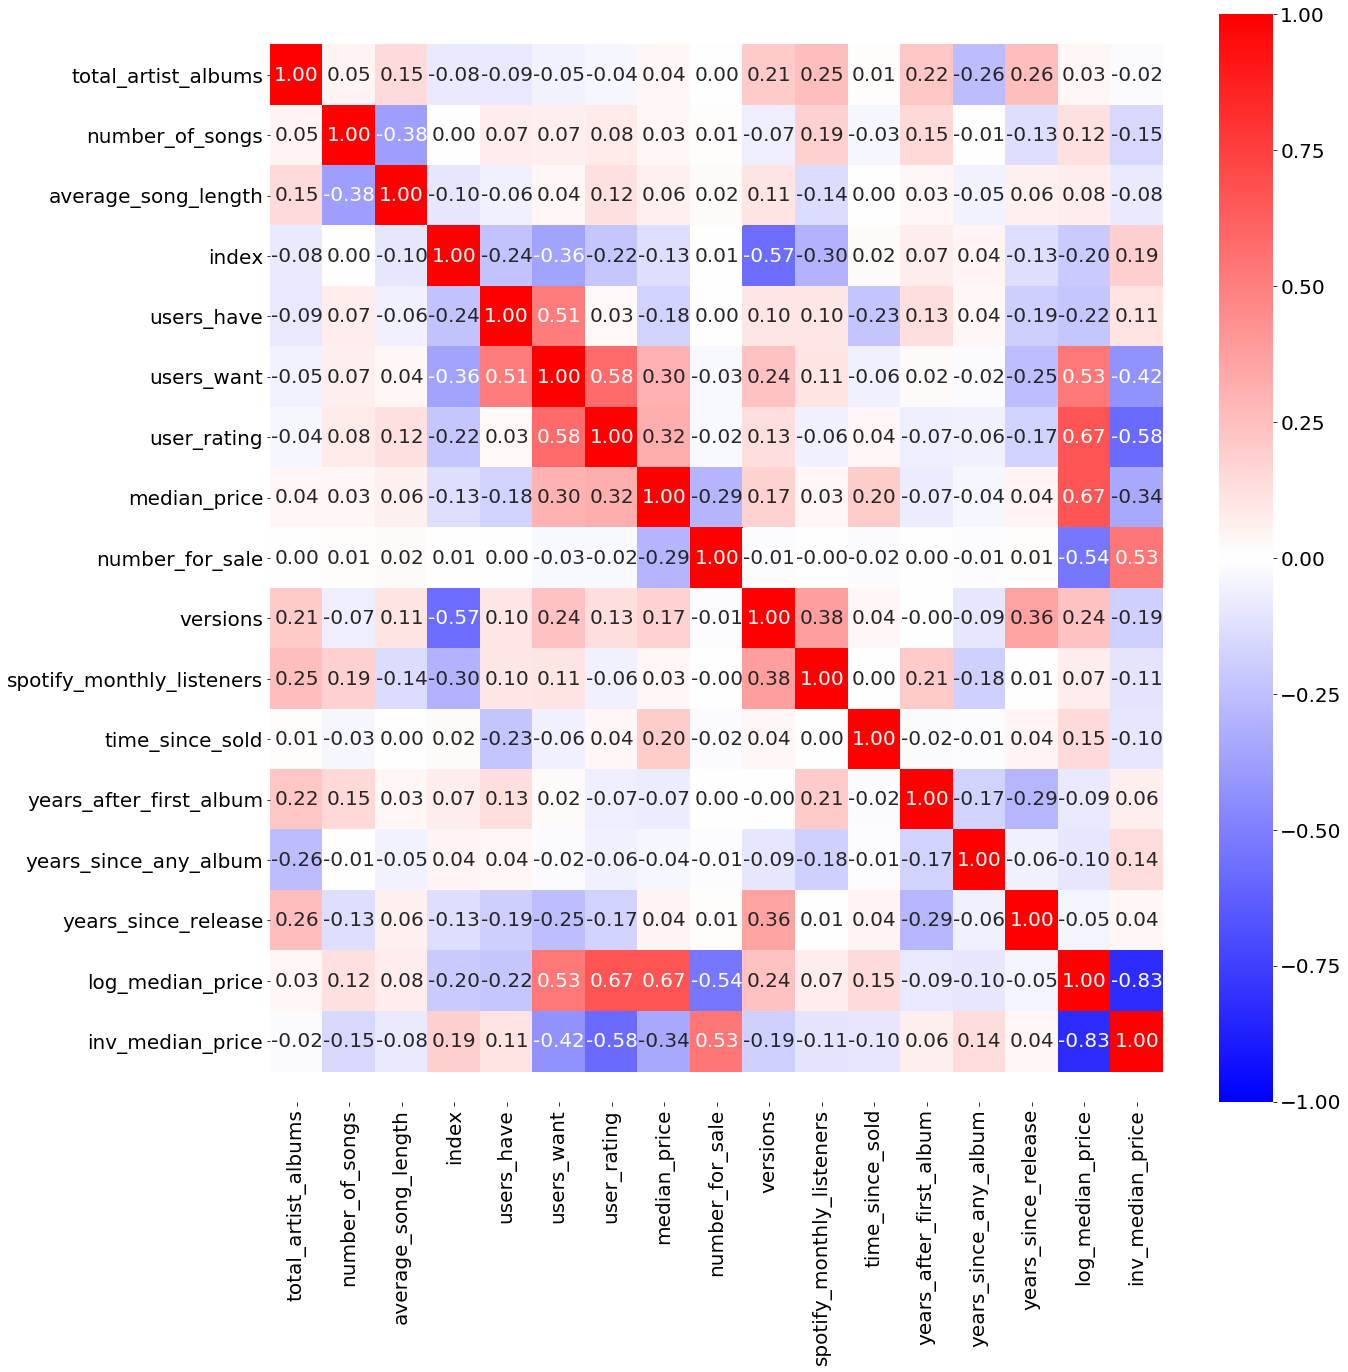

In [14]:
plt.rcParams['font.size'] = 20

plt.figure(figsize=(20,20))

sns.heatmap(df.corr(), cmap="bwr", annot=True, vmin=-1, vmax=1, fmt='.2f')

plt.gca().set_ylim(len(df.corr())+0.5, -0.5);  # quick fix to make sure viz isn't cut off

From the above heatmap, it looks like my target median_price has a positive correlation with the number of versions (re-pressings) of the album made, as well as the user rating and the number of users that want the album. It has a negative correlation with the number for sale, the number of users that have the album, and the index (position in top 1000 collected albums list - not sure I want to use this variable in modeling). 

The inverse of median_price and log of median_price has higher linear correlations with the predictor variables. For inverse, the sign on the relationships is inverted. The log of the median price has the highest linear correlations with the predictor variables, so I am going to predict the log of the median value.


The variable 'spotify_monthly_listeners' is correlated with number of songs, and total number of artist albums, which makes sense because the more material the artist has produced, the more Spotify listens there may be by chance. However, it has no or very week correlation with the target varaible. 

The variable 'number_for_sale' seems the least correlated with any other variable, and only correlated with the target. 

The variable 'avg_song_length' has the most missing values, and isn't correlated with the target or other variables other than 'number_of_songs' so I am going to drop it.

In [286]:
df.drop('average_song_length', axis=1, inplace=True)

In [287]:
df.drop(['inv_median_price','median_price'], axis=1, inplace=True)

Based on intial pairplots I realized there were two very incorrect valuse of an album being released 20 years before the artist's first album, and over a million of a record for sale. I corrected these valuse in the dataframe

In [288]:
df.loc[541,'number_for_sale'] = 220
df.loc[983,'years_after_first_album']=0

### Pairplots to look at linearity of relationships, and for interesting patterns

This first pair plot using the continous variables that are related to things intrinsic to the album (not related to users)

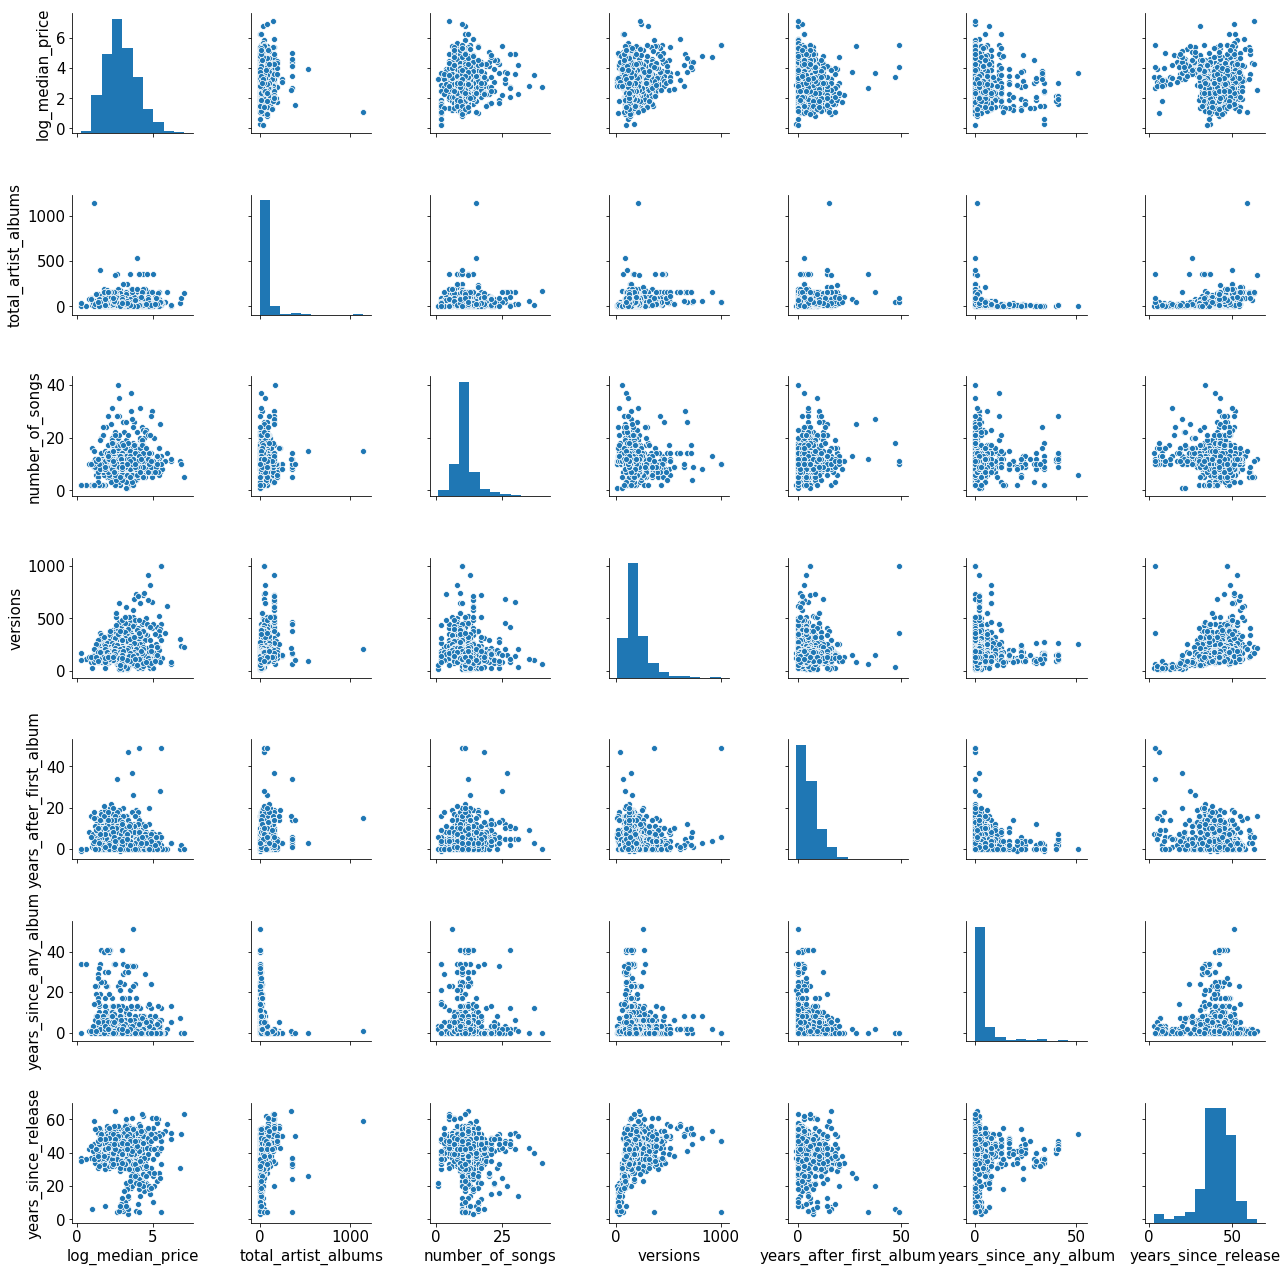

In [132]:
plt.rcParams['font.size'] = 15
sns.pairplot(data=df[['log_median_price','total_artist_albums','number_of_songs','versions','years_after_first_album','years_since_any_album','years_since_release']])

I can see the log_median_price has a somewhat linear positive relationship with number of songs and number of versions of that album. I interpret this as albums with more material being more valuable, and albums that earn money being re-pressed serveral times by record companies.

It has a somewhat linear negative relationshp with years_after_first_album and years_since_any_album. I interpret this as artist's early albums being more expensive, and record companies continuing to put out albums using material from artists they know will add more value to the record. Maybe the relationship with years_after_first_album is quadratic - newer compeliation albums of popular artists could also be more expensive.

The log_median_price has an unusual relationship with 'years_since_release'. It seems that album prices drop off sharply after a certain age. This may be because at that point the albums are all used and more likely damaged. I explore this plot more below.

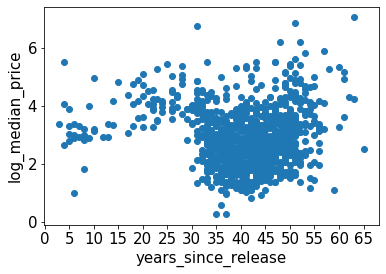

In [289]:
#It seems like when an album is less than 30 years old it sells for a higher price
#It might be useful to convert this into a categorical varialble (>30yr or <30yr)
#I keep the original 'years_since_release' since there seems to be a slight positive linear relationship overall
#I think > 30yr or < 30yr would have an interaction with 'years_since_release' 

plt.scatter(df['years_since_release'], df['log_median_price'])
plt.xticks(np.arange(0, 70, step=5))
plt.xlabel('years_since_release')
plt.ylabel('log_median_price');

In [290]:
df['less_than_30_year_old']=df['years_since_release'] <= 30
df['more_than_30_year_old']=df['years_since_release'] > 30

The variable 'total_artist_albums' looked skewed toward 0, so I log transformed it. Both the untransformed and the log-transformed version had no linear correlation with 'log_median_price'. I decided to drop 'total_artist_albums'

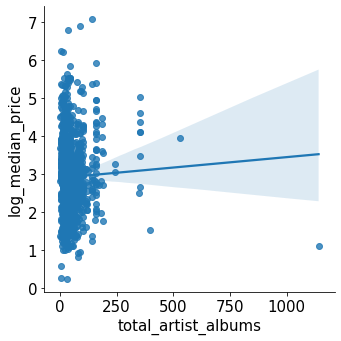

In [291]:
sns.lmplot('total_artist_albums','log_median_price',data=df)

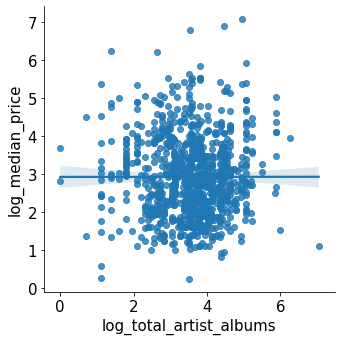

In [292]:
df['log_total_artist_albums']=np.log(df['total_artist_albums'])
sns.lmplot('log_total_artist_albums','log_median_price',data=df)

In [293]:
df.drop(['log_total_artist_albums', 'total_artist_albums'],axis=1,inplace=True)

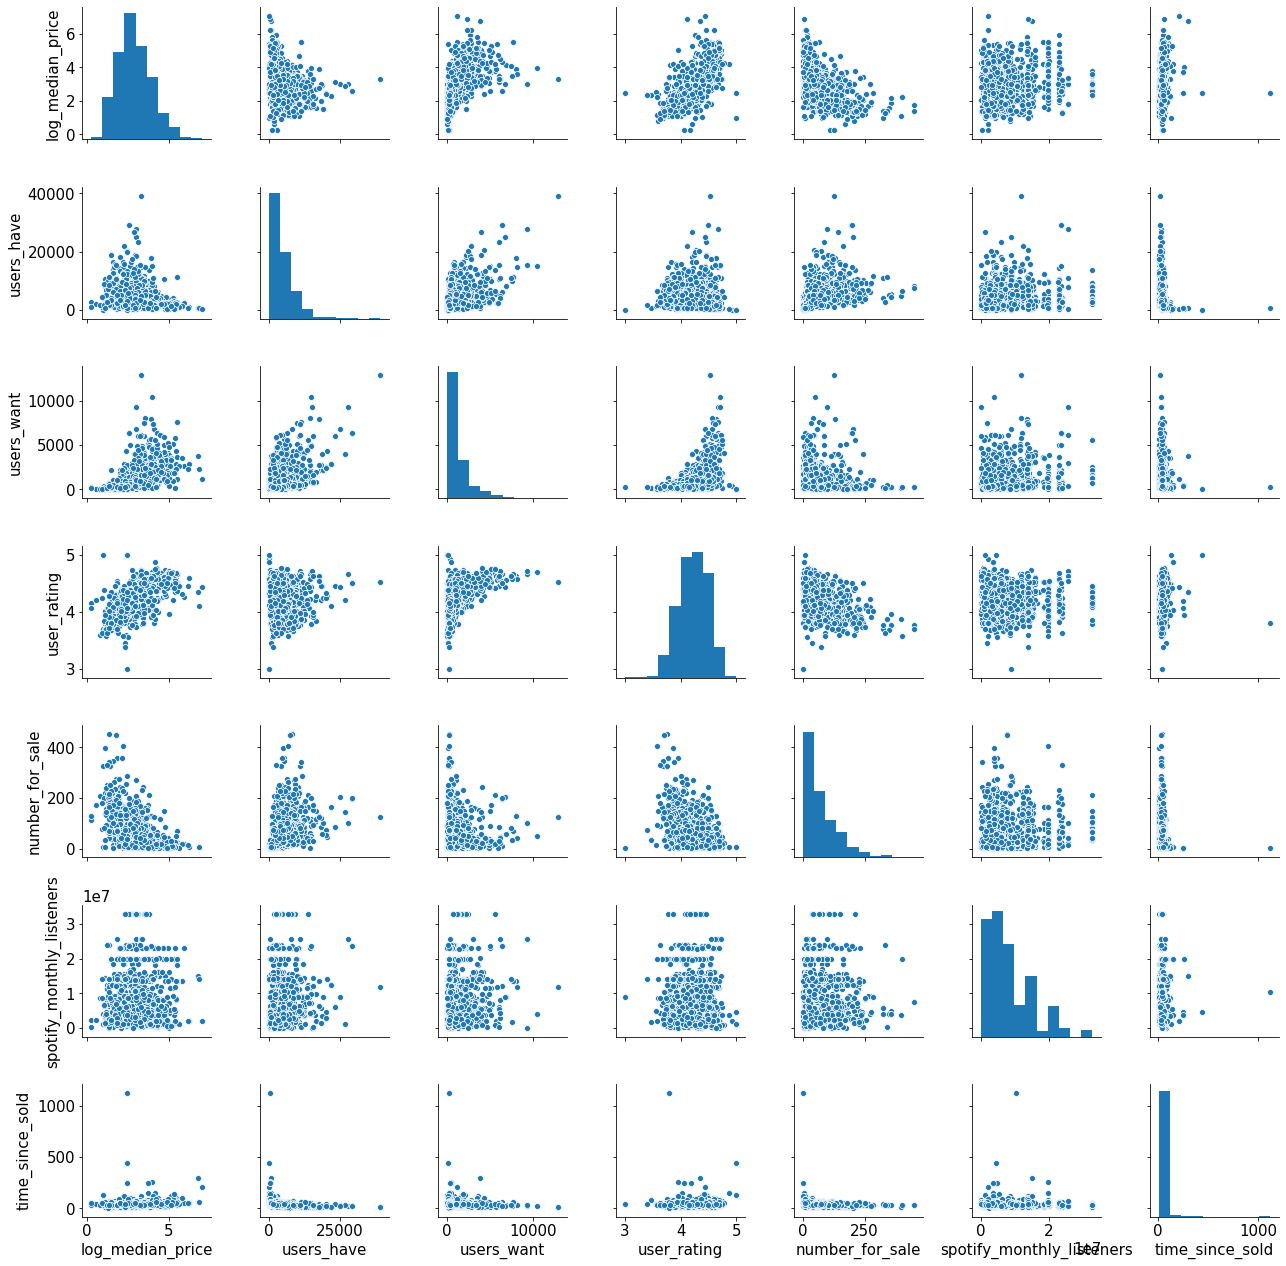

In [146]:
sns.pairplot(data=df[['log_median_price','users_have','users_want','user_rating','number_for_sale','spotify_monthly_listeners','time_since_sold']])

Here, 'log_median_price' has a positive relationship with users_want and user_rating. The relationship with user_want is not linear. 

'log_median_price' also has a negative non-linear relationship with number_for_sale. 

The variable 'time_since_sold' looked skewed toward 0, so I also tried log transforming it. Here a log transformation improved the linear relationship between it and 'log_median_price'.

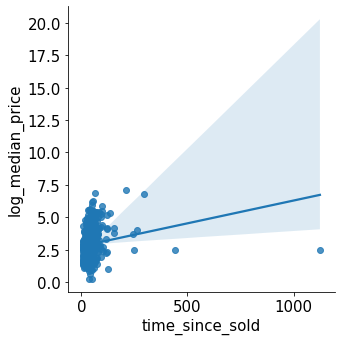

In [294]:
sns.lmplot('time_since_sold','log_median_price',data=df)

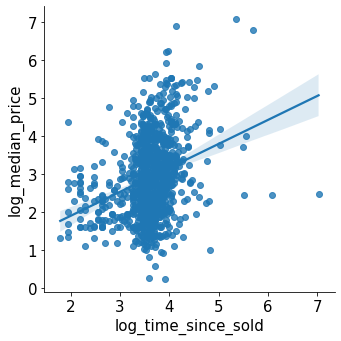

In [295]:
df['log_time_since_sold']=np.log(df['time_since_sold'])
sns.lmplot('log_time_since_sold','log_median_price',data=df)

In [296]:
df.drop('time_since_sold',axis=1,inplace=True)

In [297]:
#users_want/users_have 

In [298]:
df.columns

Index(['artists', 'albums', 'label', 'release_country', 'number_of_songs',
       'index', 'users_have', 'users_want', 'user_rating', 'styles', 'genres',
       'number_for_sale', 'versions', 'top_artists_spotify_name',
       'spotify_monthly_listeners', 'top_artists_orig_name',
       'years_after_first_album', 'years_since_any_album',
       'years_since_release', 'log_median_price', 'less_than_30_year_old',
       'more_than_30_year_old', 'log_time_since_sold'],
      dtype='object')

### Creating the categorical variable columns

First, I viewed the genres and styles columns to look for popular tags. Sometimes a tag appears in genre and sometimes it appears in styles, tags are also non-exclusive because an album can be a fusion of multiple styles. I found all rows that contained a tag of interest and created a column for that tag of 1's and 0's.

In [308]:
df['styles'].value_counts().head(20)

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 1652, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[Pop Rock]                        59
[Hard Rock]                       32
[Synth-pop]                       29
[Prog Rock]                       23
[Hard Rock, Heavy Metal]          22
[Heavy Metal]                     20
[Classic Rock]                    20
[]                                18
[Indie Rock]                      13
[Pop Rock, Classic Rock]          12
[Folk Rock]                       10
[Pop Rock, Synth-pop]             10
[New Wave]                        10
[Alternative Rock, Indie Rock]     9
[Blues Rock]                       9
[Hard Rock, Pop Rock]              8
[New Wave, Synth-pop]              8
[Hard Rock, Prog Rock]             8
[Soft Rock, Pop Rock]              7
[Alternative Rock]                 7
Name: styles, dtype: int64

In [300]:
df['Classic_Rock'] = df['styles'].apply(lambda x: 'Classic Rock' in x)
df['Classic_Rock_2'] = df['genres'].apply(lambda y: 'Classic Rock' in y)
df['Classic_Rock'] = df['Classic_Rock'] | df['Classic_Rock_2']
df.drop('Classic_Rock_2',axis=1,inplace=True)

In [301]:
df['Pop_Rock'] = df['styles'].apply(lambda x: 'Pop Rock' in x)
df['Pop_Rock_2'] = df['genres'].apply(lambda y: 'Pop Rock' in y)
df['Pop_Rock'] = df['Pop_Rock'] | df['Pop_Rock_2']
df.drop('Pop_Rock_2',axis=1,inplace=True)

In [302]:
df['Prog_Rock'] = df['styles'].apply(lambda x: 'Prog Rock' in x)
df['Prog_Rock_2'] = df['genres'].apply(lambda y: 'Prog Rock' in y)
df['Prog_Rock'] = df['Prog_Rock'] | df['Prog_Rock_2']
df.drop('Prog_Rock_2',axis=1,inplace=True)

In [303]:
df['Heavy_Metal'] = df['styles'].apply(lambda x: 'Hard Rock' in x or 'Heavy Metal' in x)
df['Heavy_Metal_2'] = df['genres'].apply(lambda y: 'Hard Rock' in y or 'Heavy Metal' in y)
df['Heavy_Metal'] = df['Heavy_Metal_2'] | df['Heavy_Metal']
df.drop('Heavy_Metal_2',axis=1,inplace=True)

In [309]:
df['Folk'] = df['styles'].apply(lambda x: 'Folk' in x or 'Folk Rock' in x)
df['Folk_2'] = df['genres'].apply(lambda y: 'Folk' in 'Fold Rock' in y)
df['Folk'] = df['Folk_2'] | df['Folk']
df.drop('Folk_2',axis=1,inplace=True)

In [310]:
df['New_Wave'] = df['styles'].apply(lambda x: 'New Wave' in x or 'Synth-Pop' in x)
df['New_Wave_2'] = df['genres'].apply(lambda y: 'New Wave' in y or 'Synth-Pop' in y)
df['New_Wave'] = df['New_Wave'] | df['New_Wave_2']
df.drop('New_Wave_2',axis=1,inplace=True)

In [311]:
df['Electronic'] = df['styles'].apply(lambda x: 'Electronic' in x)
df['Electronic_2'] = df['genres'].apply(lambda y: 'Electronic' in y)
df['Electronic'] = df['Electronic'] | df['Electronic_2']
df.drop('Electronic_2',axis=1,inplace=True)

In [312]:
df['Hip_Hop'] = df['styles'].apply(lambda x: 'Hip Hop' in x)
df['Hip_Hop_2'] = df['genres'].apply(lambda y: 'Hip Hop' in y)
df['Hip_Hop'] = df['Hip_Hop'] | df['Hip_Hop_2']
df.drop('Hip_Hop_2',axis=1,inplace=True)

In [313]:
df['Blues'] = df['styles'].apply(lambda x: 'Blues' in x or 'Blues Rock' in x)
df['Blues_2'] = df['genres'].apply(lambda y: 'Blues' in y or 'Blues Rock' in y)
df['Blues'] = df['Blues'] | df['Blues_2']
df.drop('Blues_2',axis=1,inplace=True)

In [314]:
df['Jazz'] = df['styles'].apply(lambda x: 'Jazz' in x)
df['Jazz_2'] = df['genres'].apply(lambda y: 'Jazz' in y)
df['Jazz'] = df['Jazz'] | df['Jazz_2']
df.drop('Jazz_2',axis=1,inplace=True)

In [315]:
df['Funk'] = df['styles'].apply(lambda x: 'Funk / Soul' in x)
df['Funk_2'] = df['genres'].apply(lambda y: 'Funk / Soul' in y)
df['Funk'] = df['Funk'] | df['Funk_2']
df.drop('Funk_2',axis=1,inplace=True)

In [316]:
df['Soundtrack'] = df['styles'].apply(lambda x: 'Stage & Screen' in x or 'Soundtrack' in x)
df['Soundtrack_2'] = df['genres'].apply(lambda y: 'Stage & Screen' in y or 'Soundtrack' in y)
df['Soundtrack'] = df['Soundtrack'] | df['Soundtrack_2']
df.drop('Soundtrack_2',axis=1,inplace=True)

In [317]:
df['Classic_Rock'] = df['Classic_Rock'].astype(int)
df['Pop_Rock'] = df['Pop_Rock'].astype(int)
df['Prog_Rock'] = df['Prog_Rock'].astype(int)
df['Heavy_Metal'] = df['Heavy_Metal'].astype(int)
df['Folk'] = df['Folk'].astype(int)
df['New_Wave'] = df['New_Wave'].astype(int)
df['Electronic'] = df['Electronic'].astype(int)
df['Hip_Hop'] = df['Hip_Hop'].astype(int)
df['Jazz'] = df['Jazz'].astype(int)
df['Funk'] = df['Funk'].astype(int)
df['Soundtrack'] = df['Soundtrack'].astype(int)

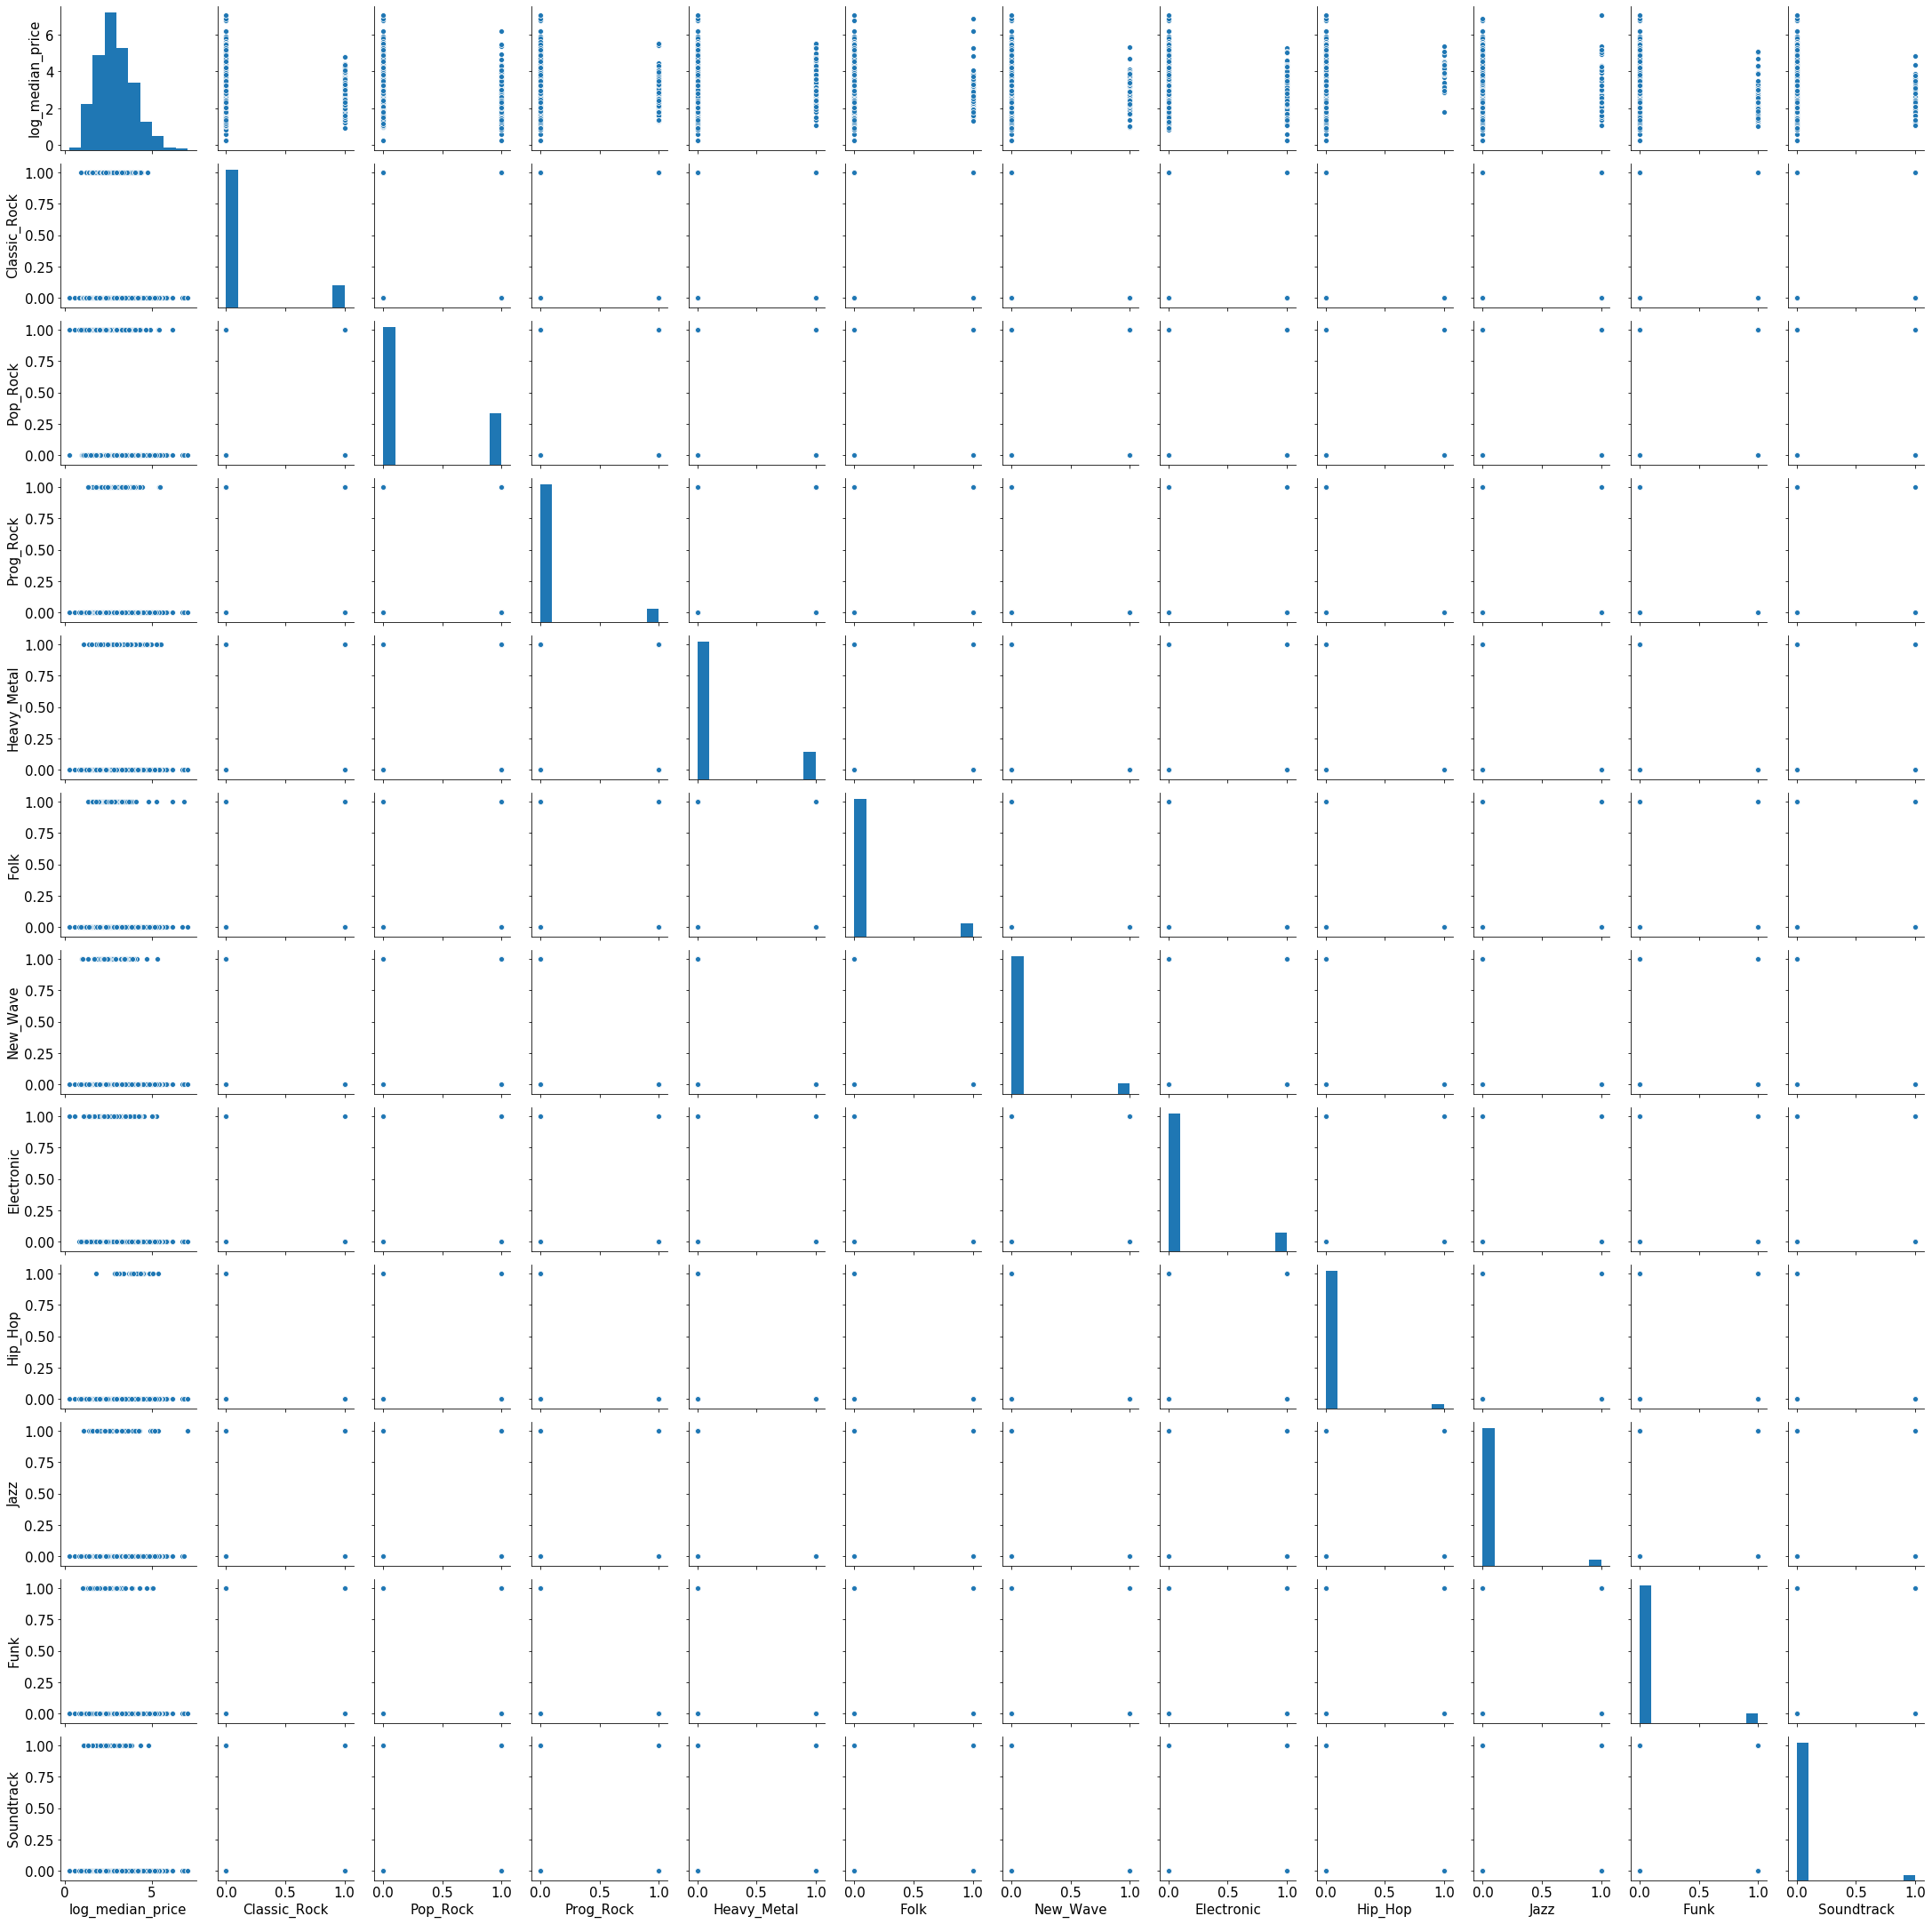

In [318]:
sns.pairplot(df[['log_median_price','Classic_Rock','Pop_Rock','Prog_Rock','Heavy_Metal','Folk','New_Wave','Electronic','Hip_Hop','Jazz','Funk','Soundtrack']])

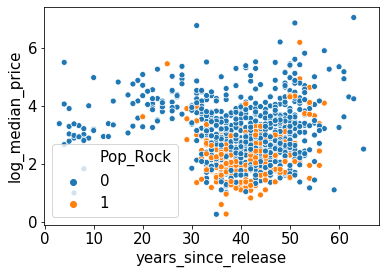

In [213]:
sns.scatterplot(df['years_since_release'],df['log_median_price'],hue=df['Pop_Rock'])

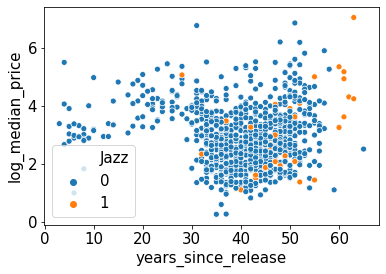

In [217]:
sns.scatterplot(df['years_since_release'],df['log_median_price'],hue=df['Jazz'])

I created country of album release dummy variables, and selected a few more common ones to keep.

In [319]:
country = pd.get_dummies(df['release_country'])

In [320]:
country.head()

,Australia,Australia & New Zealand,Canada,Europe,France,Germany,Italy,Japan,Netherlands,Sweden,UK,UK & Europe,UK & Ireland,"UK, Europe & US",US,USA & Canada,USA & Europe
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [321]:
df['release_country'].value_counts().head(10)

US                 472
UK                 410
Europe              40
UK & Europe         17
Canada              13
Australia           13
Germany             11
Sweden               7
UK, Europe & US      4
France               4
Name: release_country, dtype: int64

In [322]:
country = country[['US','UK','Europe','UK & Europe','Canada','Australia','Germany']]

I also created an artists dummy variable and kept the top 10 artists as variables

In [323]:
artist = pd.get_dummies(df['artists'])

In [324]:
df['artists'].value_counts().head(10)

The Beatles           24
Pink Floyd            20
Bob Dylan             19
David Bowie           19
The Rolling Stones    18
Genesis               14
Depeche Mode          14
Queen                 14
AC/DC                 12
Various               11
Name: artists, dtype: int64

In [325]:
top_artists=list(df['artists'].value_counts().head(10).index)

In [326]:
artist = artist[top_artists]

In [327]:
artist

,The Beatles,Pink Floyd,Bob Dylan,David Bowie,The Rolling Stones,Genesis,Depeche Mode,Queen,AC/DC,Various
0,0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
995,1,0,0,0,0,0,0,0,0,0
996,0,0,0,0,0,0,0,0,0,0
997,0,0,0,0,0,0,0,0,0,0
998,0,0,0,1,0,0,0,0,0,0


I did the same for the record labels variable

In [328]:
label = pd.get_dummies(df['label'])

In [329]:
label.columns

Index(['20th Century Records', '4AD', 'A&M Records', 'ABC Records',
       'ABC/Dunhill Records', 'ARC (3)', 'ATCO Records',
       'Aftermath Entertainment', 'Albert Productions', 'Anthem (5)',
       ...
       'WWA Records', 'Warner Bros. - Seven Arts Records',
       'Warner Bros. Records', 'Warp Records', 'Westbound Records',
       'Wilbury Records', 'Wild Bunch Records', 'XL Recordings', 'ZTT',
       'Zappa Records'],
      dtype='object', length=184)

In [330]:
df['label'].value_counts().head(10)

Columbia                90
Warner Bros. Records    48
Island Records          40
EMI                     37
Atlantic                30
Elektra                 29
Epic                    26
Capitol Records         26
A&M Records             25
Vertigo                 21
Name: label, dtype: int64

In [331]:
top_labels=list(df['label'].value_counts().head(10).index)
top_labels

['Columbia',
 'Warner Bros. Records',
 'Island Records',
 'EMI',
 'Atlantic',
 'Elektra',
 'Epic',
 'Capitol Records',
 'A&M Records',
 'Vertigo']

In [332]:
label = label[top_labels]

In [333]:
pd.concat([df,label,country,artist],axis=1).shape

(1000, 62)

In [334]:
df=pd.concat([df,label,country,artist],axis=1)

In [335]:
df.head()

,artists,albums,label,release_country,number_of_songs,index,users_have,users_want,user_rating,styles,...,The Beatles,Pink Floyd,Bob Dylan,David Bowie,The Rolling Stones,Genesis,Depeche Mode,Queen,AC/DC,Various
0,Pink Floyd,The Dark Side Of The Moon,Harvest,UK,10.0,0,11420.0,7607.0,4.67,"[Prog Rock, Psychedelic Rock]",...,0,1,0,0,0,0,0,0,0,0
1,The Beatles,Sgt. Pepper's Lonely Hearts Club Band,Parlophone,UK,13.0,1,10456.0,4967.0,4.55,"[Rock & Roll, Psychedelic Rock]",...,1,0,0,0,0,0,0,0,0,0
2,The Beatles,Abbey Road,Apple Records,UK,17.0,2,3636.0,2394.0,4.61,[Pop Rock],...,1,0,0,0,0,0,0,0,0,0
3,Pink Floyd,Wish You Were Here,Harvest,UK,4.0,3,17723.0,7965.0,4.63,[Prog Rock],...,0,1,0,0,0,0,0,0,0,0
4,Michael Jackson,Thriller,Epic,US,9.0,4,29276.0,6393.0,4.50,"[Disco, Soul]",...,0,0,0,0,0,0,0,0,0,0


Saving an updated version of the data frame

In [336]:
import pickle
with open('feature_engineering_df_1.pickle', 'wb') as write_file:
    pickle.dump(df, write_file)

In [60]:
import pickle
with open('feature_engineering_df_1.pickle', 'rb') as read_file:
    df=pickle.load(read_file)

In [61]:
df.shape

(1000, 62)

In [62]:

df.drop(['top_artists_spotify_name','top_artists_orig_name'],axis=1, inplace=True)

In [65]:
df.drop(['label','release_country','index','styles','genres'],axis=1, inplace=True)

## Train/test split

In [66]:
from sklearn.model_selection import train_test_split

In [67]:
df.dropna(how='any',axis=0,inplace=True)

In [68]:
df.columns

Index(['artists', 'albums', 'number_of_songs', 'users_have', 'users_want',
       'user_rating', 'number_for_sale', 'versions',
       'spotify_monthly_listeners', 'years_after_first_album',
       'years_since_any_album', 'years_since_release', 'log_median_price',
       'less_than_30_year_old', 'more_than_30_year_old', 'log_time_since_sold',
       'Classic_Rock', 'Pop_Rock', 'Prog_Rock', 'Heavy_Metal', 'Folk',
       'New_Wave', 'Electronic', 'Hip_Hop', 'Blues', 'Jazz', 'Funk',
       'Soundtrack', 'Columbia', 'Warner Bros. Records', 'Island Records',
       'EMI', 'Atlantic', 'Elektra', 'Epic', 'Capitol Records', 'A&M Records',
       'Vertigo', 'US', 'UK', 'Europe', 'UK & Europe', 'Canada', 'Australia',
       'Germany', 'The Beatles', 'Pink Floyd', 'Bob Dylan', 'David Bowie',
       'The Rolling Stones', 'Genesis', 'Depeche Mode', 'Queen', 'AC/DC',
       'Various'],
      dtype='object')

The train test split with an 80-20 split

In [69]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'log_median_price'], df['log_median_price'], test_size=0.2, stratify=df[['US','UK','Europe','UK & Europe','Canada','Australia','Germany']])

In [ ]:
['Classic_Rock','Pop_Rock','Prog_Rock','Heavy_Metal','Folk','New_Wave','Electronic','Hip_Hop','Blues','Jazz','Funk','Soundtrack','Columbia','Warner Bros. Records','Island Records','EMI','Atlantic','Elektra','Epic','Capitol Records','A&M Records','Vertigo','US','UK','Europe','UK & Europe','Canada','Australia','Germany','The Beatles','Pink Floyd','Bob Dylan','David Bowie','The Rolling Stones','Genesis','Depeche Mode','Queen','AC/DC','Various'

21

In [32]:
X_train.iloc[:,2:].head()

,label,release_country,number_of_songs,index,users_have,users_want,user_rating,styles,genres,number_for_sale,...,Germany,The Beatles,Pink Floyd,Bob Dylan,David Bowie,The Rolling Stones,Genesis,Depeche Mode,Queen,AC/DC
272,Epic,Europe,9.0,325,4054.0,523.0,4.10,"[Downtempo, Soul]",[Funk / Soul],157.0,...,0,0,0,0,0,0,0,0,0,0
358,Virgin,UK,10.0,414,3397.0,300.0,3.75,[Pop Rock],"[Rock, Pop]",226.0,...,0,0,0,0,0,0,0,0,0,0
979,Polydor,UK,7.0,1046,2945.0,204.0,3.90,"[Soundtrack, Modern Classical, Score, Ambient]","[Electronic, Stage & Screen]",206.0,...,0,0,0,0,0,0,0,0,0,0
103,Track Record,UK,24.0,155,2486.0,1444.0,4.25,"[Rock Opera, Art Rock]",[Rock],50.0,...,0,0,0,0,0,0,0,0,0,0
255,Mute,UK,10.0,308,2760.0,1616.0,4.45,[Synth-pop],"[Electronic, Rock]",34.0,...,0,0,0,0,0,0,0,1,0,0


In [144]:
X_train.columns

Index(['artists', 'albums', 'number_of_songs', 'users_have', 'users_want',
       'user_rating', 'number_for_sale', 'versions',
       'spotify_monthly_listeners', 'years_after_first_album',
       'years_since_any_album', 'years_since_release', 'less_than_30_year_old',
       'more_than_30_year_old', 'log_time_since_sold', 'Classic_Rock',
       'Pop_Rock', 'Prog_Rock', 'Heavy_Metal', 'Folk', 'New_Wave',
       'Electronic', 'Hip_Hop', 'Blues', 'Jazz', 'Funk', 'Soundtrack',
       'Columbia', 'Warner Bros. Records', 'Island Records', 'EMI', 'Atlantic',
       'Elektra', 'Epic', 'Capitol Records', 'A&M Records', 'Vertigo', 'US',
       'UK', 'Europe', 'UK & Europe', 'Canada', 'Australia', 'Germany',
       'The Beatles', 'Pink Floyd', 'Bob Dylan', 'David Bowie',
       'The Rolling Stones', 'Genesis', 'Depeche Mode', 'Queen', 'AC/DC',
       'Various', 'users_want**2', 'years_since_any_album**2',
       'years_after_first_album**2', 'number_of_songs*Electronic',
       'number_for_sale

### Exploration of polynomial and interaction variables

Working with training data, I explored polynomial and interaction variables since I noticed they may be present in data visualization above. I used a naive approach to identify terms that may have predictive power, by creating all possible terms and then creating a model with statsmodel OLS. I looked at the terms with coefficients having a low p-value and graphed them to find interesting ones.

In [340]:
from sklearn.preprocessing import PolynomialFeatures

In [364]:
p = PolynomialFeatures()
X_train_poly = p.fit_transform(X_train.iloc[:,2:])

Linear model with continuous features from statsmodel

In [370]:
import statsmodels.api as sm

In [376]:
Y_sm = np.array(y_train)
X_sm = X_train_poly

In [378]:
model = sm.OLS(Y_sm, sm.add_constant(X_sm)) 

In [379]:
fit = model.fit()

In [380]:
fit.summary()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     40.18
Date:                Tue, 06 Oct 2020   Prob (F-statistic):          9.55e-243
Time:                        15:47:36   Log-Likelihood:                -141.58
No. Observations:                 764   AIC:                             613.2
Df Residuals:                     599   BIC:                             1379.
Df Model:                         164                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.001      0.700      0.484      -0.002       0.004
x1             0.0099      0.008      1.284      0.200      -0.005       0.025
x2         -6.157e-05      0.000     -0.386      0.699      -0.000       0.000
x3             0.0019      0.001      3.358      0.001       0.001       0.003
x4             0.0090      0.004      2.291      0.022       0.001       0.017
x5            -0.0088      0.008     -1.132      0.258      -0.024       0.006
x6             0.0018      0.004      0.419      0.675      -0.007       0.010
x7          1.722e-07   6.82e-08      2.526      0.012    3.83e-08    3.06e-07
x8             0.0147      0.007      2.178      0.030       0.001       0.028
x9            -0.0106      0.006     -1.658      0.098      -0.023       0.002
x10           -0.0327      0.021     -1.592      0.112      -0.073       0.008
x11            0.0025      0.001      2.398      0.017       0.000       0.004
x12           -0.0010      0.001     -1.188      0.235      -0.003       0.001
x13            0.0035      0.002      1.475      0.141      -0.001       0.008
x14            0.0007      0.001      1.100      0.272      -0.001       0.002
x15            0.0023      0.003      0.842      0.400      -0.003       0.008
x16            0.0003      0.000      0.581      0.561      -0.001       0.001
x17            0.0042      0.002      2.178      0.030       0.000       0.008
x18           -0.0029      0.001     -2.294      0.022      -0.005      -0.000
x19           -0.0001      0.001     -0.154      0.878      -0.001       0.001
x20            0.0008      0.002      0.430      0.667      -0.003       0.004
x21           -0.0010      0.001     -1.363      0.173      -0.002       0.000
x22           -0.0005      0.002     -0.287      0.774      -0.004       0.003
x23            0.0010      0.001      1.155      0.248      -0.001       0.003
x24           -0.0016      0.002     -0.888      0.375      -0.005       0.002
x25            0.0020      0.001      1.768      0.078      -0.000       0.004
x26           -0.0005      0.001     -0.763      0.446      -0.002       0.001
x27            0.0021      0.001      1.516      0.130      -0.001       0.005
x28            0.0003      0.001      0.657      0.511      -0.001       0.001
x29            0.0007      0.001      1.194      0.233      -0.000       0.002
x30           -0.0003      0.000     -0.653      0.514      -0.001       0.001
x31            0.0013      0.001      1.283      0.200      -0.001       0.003
x32            0.0018      0.001      2.232      0.026       0.000       0.003
x33            0.0012      0.001      1.089      0.276      -0.001       0.003
x34            0.0012      0.001      1.508      0.132      -0.000       0.003
x35           -0.0002      0.000     -0.497      0.619      -0.001       0.000
x3

In [384]:
X_train_poly.shape

(764, 1431)

The R^2 is 0.7 which is good off the bat, the users_have, users_want, time_since_last_sold, and number_for_sale may be too directly related to marketplace value, I could try to improve a model without them. 

average_song_length is not a strong predictor (the coefficient 95% confidence interval includes 0) and it has a lot of NaN values, so I will drop it.

total_artist_albums and spotify_monthly_listeners were correlated with eachother, and neither one has a significant coefficient here. years_since_any_album is also a weak predictor with a coefficient that is not significant. 

In [389]:
poly_features_names = p.get_feature_names(X_train.iloc[:,2:].columns)

In [401]:
highly_sig_poly_features = [i for i in range(len(fit.pvalues)) if fit.pvalues[i] < 0.01]

[3,
 36,
 41,
 72,
 93,
 108,
 138,
 145,
 151,
 156,
 158,
 164,
 165,
 189,
 192,
 198,
 201,
 238,
 285,
 292,
 298,
 310,
 355,
 358,
 361,
 364,
 365,
 371,
 391,
 396,
 397,
 399,
 412,
 426,
 441,
 448,
 452,
 458,
 480,
 530,
 553,
 584,
 606,
 634,
 646,
 679,
 685,
 703,
 716,
 750,
 794,
 811,
 819,
 837,
 858,
 874,
 886,
 896,
 955,
 1014,
 1028,
 1278,
 1289,
 1302,
 1306,
 1321,
 1353,
 1416]

In [402]:
[poly_features_names[i] for i in highly_sig_poly_features]

['users_want',
 'US',
 'Australia',
 'number_of_songs Electronic',
 'number_of_songs Australia',
 'users_have number_for_sale',
 'users_have Vertigo',
 'users_have Germany',
 'users_have Genesis',
 'users_want^2',
 'users_want number_for_sale',
 'users_want less_than_30_year_old',
 'users_want more_than_30_year_old',
 'users_want US',
 'users_want UK & Europe',
 'users_want Bob Dylan',
 'users_want Genesis',
 'user_rating US',
 'number_for_sale Vertigo',
 'number_for_sale Germany',
 'number_for_sale Genesis',
 'versions log_time_since_sold',
 'spotify_monthly_listeners more_than_30_year_old',
 'spotify_monthly_listeners Pop_Rock',
 'spotify_monthly_listeners Folk',
 'spotify_monthly_listeners Hip_Hop',
 'spotify_monthly_listeners Blues',
 'spotify_monthly_listeners Island Records',
 'spotify_monthly_listeners Genesis',
 'years_after_first_album^2',
 'years_after_first_album years_since_any_album',
 'years_after_first_album less_than_30_year_old',
 'years_after_first_album Funk',
 'year

For polynomial terms, users_want^2, years_after_first_album^2, and years_since_any_album^2 
Since US is categorical, I don't think US^2 makes sense to use. 

In [70]:
X_train["users_want**2"]= X_train["users_want"]**2
X_train['years_since_any_album**2'] = X_train['years_since_any_album']**2
X_train['years_after_first_album**2'] = X_train['years_after_first_album']**2

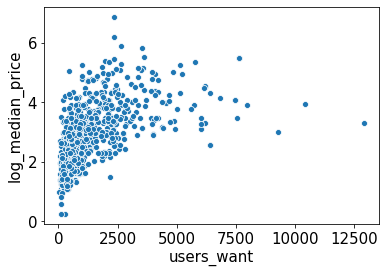

In [412]:
sns.scatterplot(X_train['users_want'],y_train)

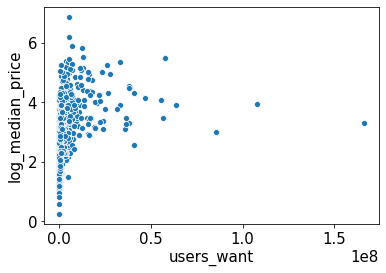

In [514]:
sns.scatterplot(X_train['users_want']**2,y_train)

Plotting some of the interaction terms from above to look for strong ones, and ones that affect a lot datapoints. 

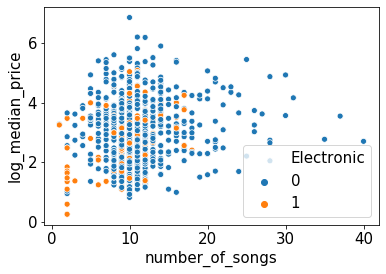

In [419]:
sns.scatterplot(df['number_of_songs'],df['log_median_price'],hue=df['Electronic'])

In [71]:
X_train['number_of_songs*Electronic'] = X_train['number_of_songs']*X_train['Electronic']

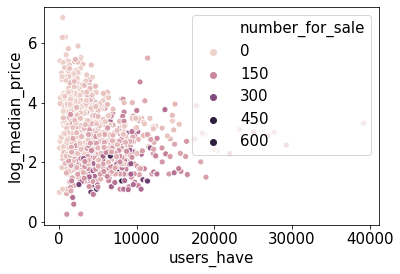

In [452]:
sns.scatterplot(df['users_have'],df['log_median_price'],hue=df['number_for_sale'])

In [72]:
X_train['number_for_sale*users_have']=X_train['users_have'] * X_train['number_for_sale']

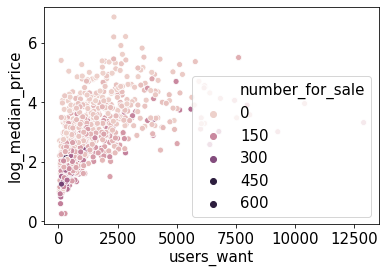

In [453]:
sns.scatterplot(df['users_want'],df['log_median_price'],hue=df['number_for_sale'])

In [73]:
X_train['number_for_sale*users_want']=X_train['number_for_sale']*X_train['users_want']

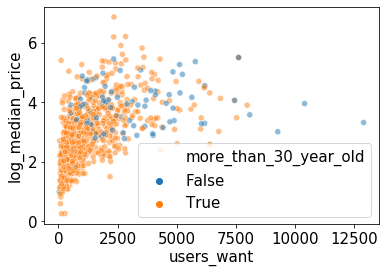

In [450]:
sns.scatterplot(df['users_want'],df['log_median_price'],hue=df['more_than_30_year_old'],alpha=0.5)

In [74]:
X_train['users_want*more_than_30'] = X_train['users_want'] * X_train['more_than_30_year_old']

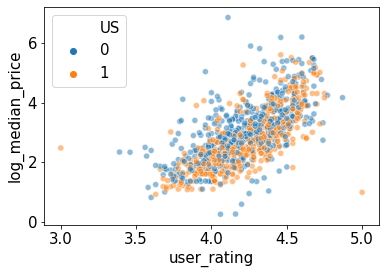

In [449]:
sns.scatterplot(df['user_rating'],df['log_median_price'],hue=df['US'],alpha=0.5)

In [75]:
X_train['user_rating*US'] = X_train['user_rating'] * X_train['US']

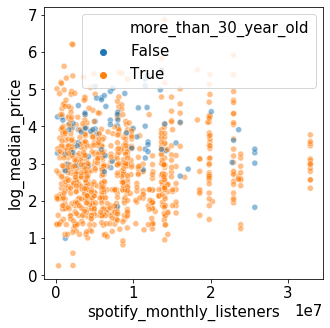

In [635]:
plt.figure(figsize=(5,5))
sns.scatterplot(df['spotify_monthly_listeners'],df['log_median_price'],hue=df['more_than_30_year_old'], alpha=0.5)

In [76]:
X_train['spotify_monthly*more_than_30'] = X_train['spotify_monthly_listeners'] * X_train['more_than_30_year_old']

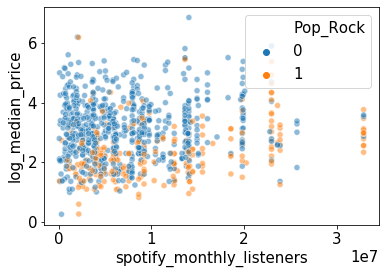

In [463]:
sns.scatterplot(df['spotify_monthly_listeners'],df['log_median_price'],hue=df['Pop_Rock'], alpha=0.5)

In [77]:
X_train['spotify_monthly*Pop_Rock'] = X_train['spotify_monthly_listeners'] * X_train['Pop_Rock']

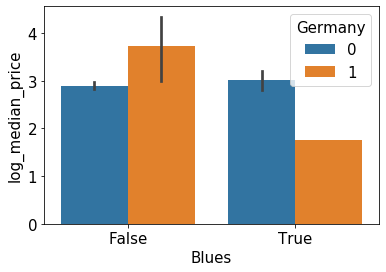

In [484]:
sns.barplot(df['Blues'],df['log_median_price'],hue=df['Germany'])

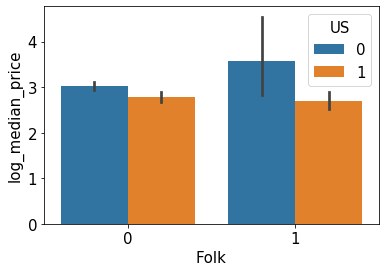

In [491]:
sns.barplot(df['Folk'],df['log_median_price'],hue=df['US'])

In [78]:
X_train['Folk*US']=X_train["Folk"] * X_train['US']

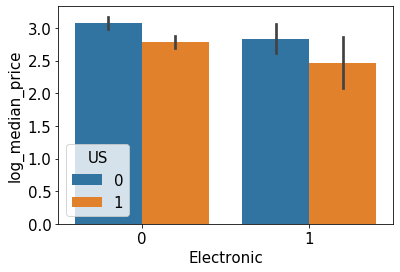

In [509]:
sns.barplot(df['Electronic'],df['log_median_price'],hue=df['US'])

In [79]:
X_train['Electronic*US']=X_train['Electronic'] * X_train['US']

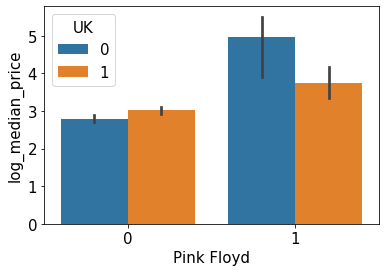

In [493]:
sns.barplot(df['Pink Floyd'],df['log_median_price'],hue=df['UK'])

In [80]:
X_train['PinkFloyd*UK']=X_train["Pink Floyd"] * X_train['UK']

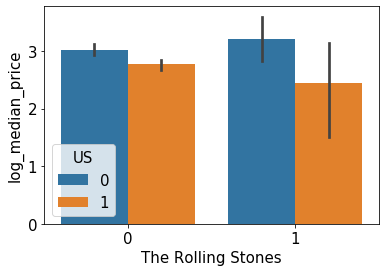

In [494]:
sns.barplot(df['The Rolling Stones'],df['log_median_price'],hue=df['US'])

In [81]:
X_train['RollingStones*US'] = X_train['The Rolling Stones'] * X_train["US"]

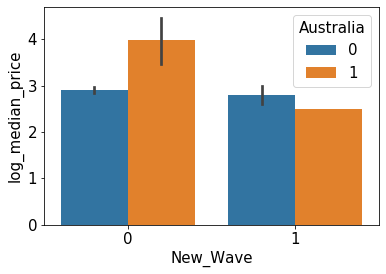

In [508]:
sns.barplot(df['New_Wave'],df['log_median_price'],hue=df['Australia'])

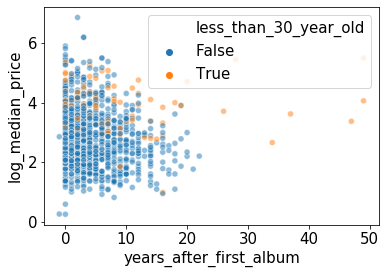

In [506]:
sns.scatterplot(df['years_after_first_album'],df['log_median_price'],hue=df['less_than_30_year_old'],alpha=0.5)

In [82]:
X_train['years_after_first_album*less_than_30']=X_train['years_after_first_album'] * X_train['less_than_30_year_old']



Excluding some of the others because they apply only to a small number of samples

In [83]:
X_train.columns

Index(['artists', 'albums', 'number_of_songs', 'users_have', 'users_want',
       'user_rating', 'number_for_sale', 'versions',
       'spotify_monthly_listeners', 'years_after_first_album',
       'years_since_any_album', 'years_since_release', 'less_than_30_year_old',
       'more_than_30_year_old', 'log_time_since_sold', 'Classic_Rock',
       'Pop_Rock', 'Prog_Rock', 'Heavy_Metal', 'Folk', 'New_Wave',
       'Electronic', 'Hip_Hop', 'Blues', 'Jazz', 'Funk', 'Soundtrack',
       'Columbia', 'Warner Bros. Records', 'Island Records', 'EMI', 'Atlantic',
       'Elektra', 'Epic', 'Capitol Records', 'A&M Records', 'Vertigo', 'US',
       'UK', 'Europe', 'UK & Europe', 'Canada', 'Australia', 'Germany',
       'The Beatles', 'Pink Floyd', 'Bob Dylan', 'David Bowie',
       'The Rolling Stones', 'Genesis', 'Depeche Mode', 'Queen', 'AC/DC',
       'Various', 'users_want**2', 'years_since_any_album**2',
       'years_after_first_album**2', 'number_of_songs*Electronic',
       'number_for_sale

In [84]:
X_train.iloc[:,2:].shape

(764, 67)

In [85]:
X_train=X_train.reindex()
y_train=y_train.reindex()

### First linear model in sklearn

In [48]:
from sklearn.model_selection import KFold

In [51]:
from sklearn.linear_model import LinearRegression

In [53]:
import numpy as np

In [86]:
kf = KFold(n_splits=5, shuffle=True, random_state = 71)

cv_lm_r2s = [] 

for train_ind, val_ind in kf.split(X_train,y_train):
    #print(train_ind)
    X_train_cv, y_train_cv = X_train.iloc[train_ind], y_train.iloc[train_ind]
    X_val, y_val = X_train.iloc[val_ind], y_train.iloc[val_ind]
    #print(X_train_cv.shape)
    #print(X_val.shape)
    #print(y_train_cv.shape)
    #print(y_val.shape)
    #simple linear regression
    lm = LinearRegression()
    
    y_train_cv=np.array(y_train_cv).reshape(-1,1)
    y_val=np.array(y_val).reshape(-1,1)

    lm.fit(X_train_cv.iloc[:,2:], y_train_cv)
    cv_lm_r2s.append((lm.score(X_train_cv.iloc[:,2:], y_train_cv),lm.score(X_val.iloc[:,2:], y_val)))

In [87]:
cv_lm_r2s

[(0.7965969271734016, 0.6965681420534648),
 (0.8104154198534004, 0.6189688825677528),
 (0.7839559800955033, 0.7637695676857886),
 (0.7908210083063174, 0.7202481114742292),
 (0.7905009706927648, 0.7128405314504013)]

The first column of training set R^2 is always higher than the test set R^2. It is overfit, and I should use Lasso or Ridge to increase fitting on test sets

In [826]:
y_val.shape

(152, 1)

In [827]:
X_val.shape

(152, 69)

In [828]:
y_train_cv.shape

(612, 1)

In [829]:
X_train_cv.shape

(612, 69)

In [88]:
lm = LinearRegression()

lm.fit(X_train.iloc[:,2:],y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

The R^2 of a model trained on the training set itself is very high, and the mean squared error is very low (this MSE is in terms of log(dollars))

In [89]:
#R^2
lm.score(X_train.iloc[:,2:], y_train)

0.7866026708967175

In [90]:
#MSE
np.sum((lm.predict(X_train.iloc[:,2:]) - y_train)*2) / len(y_train)

-7.323984350930352e-16

I have to add in all the same new features to the test set 

In [91]:
X_test["users_want**2"]= X_test["users_want"]**2
X_test['years_since_any_album**2'] = X_test['years_since_any_album']**2
X_test['years_after_first_album**2'] = X_test['years_after_first_album']**2


X_test['number_for_sale*users_have']=X_test['users_have'] * X_test['number_for_sale']
X_test['number_for_sale*users_want']=X_test['number_for_sale']*X_test['users_want']
X_test['users_want*more_than_30'] = X_test['users_want'] * X_test['more_than_30_year_old']
X_test['user_rating*US'] = X_test['user_rating'] * X_test['US']
X_test['spotify_monthly*more_than_30'] = X_test['spotify_monthly_listeners'] * X_test['more_than_30_year_old']
X_test['spotify_monthly*Pop_Rock'] = X_test['spotify_monthly_listeners'] * X_test['Pop_Rock']
X_test['Folk*US']=X_test["Folk"] * X_test['US']
X_test['Electronic*US']=X_test['Electronic'] * X_test['US']
X_test['PinkFloyd*UK']=X_test["Pink Floyd"] * X_test['UK']
X_test['RollingStones*US'] = X_test['The Rolling Stones'] * X_test["US"]
X_test['years_after_first_album*less_than_30']=X_test['years_after_first_album'] * X_test['less_than_30_year_old']
X_test['number_of_songs*Electronic'] = X_test['number_of_songs']*X_test['Electronic']


In [108]:
X_test = X_test.loc[:,X_train.columns]

Wow! The R^2 and MSE from a standard linear regression is terrible on the test set. This model is very overfit.

In [109]:
lm.score(X_test.iloc[:,2:], y_test)

0.7956266460527177

In [110]:
np.sum((lm.predict(X_test.iloc[:,2:]) - y_test)*2) / len(y_test)

0.026721300022117644

I know I wasn't supposed to look at the hold out test set yet. But I was curious. I am confused as to why the K-fold validation scores were all pretty similar, but the test-set score was so poor. Is it outliers?

In [111]:
y_test.describe()

count    191.000000
mean       2.934745
std        1.059268
min        0.254642
25%        2.243869
50%        2.807594
75%        3.480009
max        6.871288
Name: log_median_price, dtype: float64

In [112]:
y_train.describe()

count    764.000000
mean       2.903241
std        1.006317
min        0.262364
25%        2.169338
50%        2.836150
75%        3.555776
max        6.201543
Name: log_median_price, dtype: float64

In [113]:
residuals = lm.predict(X_test.iloc[:,2:]) - y_test
residuals 


396    0.334694
814    0.028553
580   -1.107520
402    0.191223
963    0.141611
         ...   
170    0.120679
832   -0.121671
472   -0.016737
892   -0.535810
478   -0.683712
Name: log_median_price, Length: 191, dtype: float64

In [114]:
import pandas as pd

In [115]:
residuals_check = pd.DataFrame({'artist':X_test['artists'],'album':X_test['albums'],'residual':residuals,'price':y_test})

In [116]:
residuals_check.sort_values('residual',ascending=False)

,artist,album,residual,price
713,Boards Of Canada,Music Has The Right To Children,1.274569,4.255187
855,Paul Hardcastle,19,1.035957,0.254642
687,Styx,Pieces Of Eight,0.985120,1.386294
190,Daft Punk,Discovery,0.933380,3.582685
4,Michael Jackson,Thriller,0.926650,2.583243
...,...,...,...,...
953,Muse,Origin Of Symmetry,-1.044885,4.885450
518,David Bowie,Tonight,-1.050967,2.400619
0,Pink Floyd,The Dark Side Of The Moon,-1.091949,5.508376
580,Nick Drake,Pink Moon,-1.107520,6.213427


In [102]:
X_test.shape

(191, 69)

In [103]:
X_train.shape

(764, 69)

In [104]:
X_train.columns

Index(['artists', 'albums', 'number_of_songs', 'users_have', 'users_want',
       'user_rating', 'number_for_sale', 'versions',
       'spotify_monthly_listeners', 'years_after_first_album',
       'years_since_any_album', 'years_since_release', 'less_than_30_year_old',
       'more_than_30_year_old', 'log_time_since_sold', 'Classic_Rock',
       'Pop_Rock', 'Prog_Rock', 'Heavy_Metal', 'Folk', 'New_Wave',
       'Electronic', 'Hip_Hop', 'Blues', 'Jazz', 'Funk', 'Soundtrack',
       'Columbia', 'Warner Bros. Records', 'Island Records', 'EMI', 'Atlantic',
       'Elektra', 'Epic', 'Capitol Records', 'A&M Records', 'Vertigo', 'US',
       'UK', 'Europe', 'UK & Europe', 'Canada', 'Australia', 'Germany',
       'The Beatles', 'Pink Floyd', 'Bob Dylan', 'David Bowie',
       'The Rolling Stones', 'Genesis', 'Depeche Mode', 'Queen', 'AC/DC',
       'Various', 'users_want**2', 'years_since_any_album**2',
       'years_after_first_album**2', 'number_of_songs*Electronic',
       'number_for_sale

In [105]:
X_test.columns

Index(['artists', 'albums', 'number_of_songs', 'users_have', 'users_want',
       'user_rating', 'number_for_sale', 'versions',
       'spotify_monthly_listeners', 'years_after_first_album',
       'years_since_any_album', 'years_since_release', 'less_than_30_year_old',
       'more_than_30_year_old', 'log_time_since_sold', 'Classic_Rock',
       'Pop_Rock', 'Prog_Rock', 'Heavy_Metal', 'Folk', 'New_Wave',
       'Electronic', 'Hip_Hop', 'Blues', 'Jazz', 'Funk', 'Soundtrack',
       'Columbia', 'Warner Bros. Records', 'Island Records', 'EMI', 'Atlantic',
       'Elektra', 'Epic', 'Capitol Records', 'A&M Records', 'Vertigo', 'US',
       'UK', 'Europe', 'UK & Europe', 'Canada', 'Australia', 'Germany',
       'The Beatles', 'Pink Floyd', 'Bob Dylan', 'David Bowie',
       'The Rolling Stones', 'Genesis', 'Depeche Mode', 'Queen', 'AC/DC',
       'Various', 'users_want**2', 'years_since_any_album**2',
       'years_after_first_album**2', 'number_for_sale*users_have',
       'number_for_sale

In [106]:
X_test = X_test.loc[:,X_train.columns]

In [107]:
X_test.columns

Index(['artists', 'albums', 'number_of_songs', 'users_have', 'users_want',
       'user_rating', 'number_for_sale', 'versions',
       'spotify_monthly_listeners', 'years_after_first_album',
       'years_since_any_album', 'years_since_release', 'less_than_30_year_old',
       'more_than_30_year_old', 'log_time_since_sold', 'Classic_Rock',
       'Pop_Rock', 'Prog_Rock', 'Heavy_Metal', 'Folk', 'New_Wave',
       'Electronic', 'Hip_Hop', 'Blues', 'Jazz', 'Funk', 'Soundtrack',
       'Columbia', 'Warner Bros. Records', 'Island Records', 'EMI', 'Atlantic',
       'Elektra', 'Epic', 'Capitol Records', 'A&M Records', 'Vertigo', 'US',
       'UK', 'Europe', 'UK & Europe', 'Canada', 'Australia', 'Germany',
       'The Beatles', 'Pink Floyd', 'Bob Dylan', 'David Bowie',
       'The Rolling Stones', 'Genesis', 'Depeche Mode', 'Queen', 'AC/DC',
       'Various', 'users_want**2', 'years_since_any_album**2',
       'years_after_first_album**2', 'number_of_songs*Electronic',
       'number_for_sale

In [914]:
print(X_train['Classic_Rock'].sum())
print(X_test['Classic_Rock'].sum())
print(X_train['Pink Floyd'].sum())
print(X_test['Pink Floyd'].sum())
print(X_train['US'].sum())
print(X_test['US'].sum())

-1.2434497875801753e-14
8.881784197001252e-16
-2.7533531010703882e-14
-3.552713678800501e-15
7.016609515630989e-14
1.5987211554602254e-14


The test set doesnt have a higher minimum value, or a higher maximum value, than the training set. I don't understand this.

### Scaling 

While variables do not need to be scaled for stanard linear regression, the penalities from Lasso and Ridge regression will not be able to be applied evenly on non-scaled variables. For Lasso and Ridge to perform optimally, I am going to scale my variables with StandardScaler (Z-score transformation).

In [117]:
from sklearn.preprocessing import StandardScaler

I need to scale the categorical varialbes as well, so the variables with more 1's don't have more weight in the penalty score from Lasso or Ridge. 

In [118]:
scaler = StandardScaler()
X_train.iloc[:,2:] = scaler.fit_transform(X_train.iloc[:,2:])
X_test.iloc[:,2:] = scaler.fit_transform(X_test.iloc[:,2:])

In [841]:
X_train.describe()

,number_of_songs,users_have,users_want,user_rating,number_for_sale,versions,spotify_monthly_listeners,years_after_first_album,years_since_any_album,years_since_release,...,users_want*more_than_30,user_rating*US,spotify_monthly*more_than_30,spotify_monthly*Pop_Rock,Folk*US,Electronic*US,PinkFloyd*UK,RollingStones*US,years_after_first_album*less_than_30,number_of_songs*Electronic
count,7.640000e+02,7.640000e+02,7.640000e+02,7.640000e+02,7.640000e+02,7.640000e+02,7.640000e+02,7.640000e+02,7.640000e+02,7.640000e+02,...,7.640000e+02,7.640000e+02,7.640000e+02,7.640000e+02,7.640000e+02,7.640000e+02,7.640000e+02,7.640000e+02,7.640000e+02,7.640000e+02
mean,-1.309308e-16,-9.162246e-17,-4.501199e-17,-2.363147e-15,-1.183608e-16,-1.620286e-16,1.329652e-16,1.395045e-17,5.522052e-18,2.470392e-16,...,-4.755504e-17,-3.226041e-17,6.437550e-17,-6.582867e-17,1.922546e-16,-2.640049e-16,-6.103320e-18,9.358424e-17,-2.115091e-16,8.413863e-17
std,1.000655e+00,1.000655e+00,1.000655e+00,1.000655e+00,1.000655e+00,1.000655e+00,1.000655e+00,1.000655e+00,1.000655e+00,1.000655e+00,...,1.000655e+00,1.000655e+00,1.000655e+00,1.000655e+00,1.000655e+00,1.000655e+00,1.000655e+00,1.000655e+00,1.000655e+00,1.000655e+00
min,-2.318691e+00,-1.179925e+00,-8.719016e-01,-4.657729e+00,-1.076326e+00,-1.507135e+00,-1.237777e+00,-1.112030e+00,-5.297090e-01,-3.778655e+00,...,-8.500591e-01,-8.877240e-01,-1.096820e+00,-4.811565e-01,-2.702475e-01,-1.208645e-01,-1.415157e-01,-6.278679e-02,-2.028099e-01,-3.422203e-01
25%,-4.123364e-01,-6.543749e-01,-6.277508e-01,-7.210337e-01,-6.875934e-01,-5.775324e-01,-7.193420e-01,-7.566268e-01,-5.297090e-01,-4.221582e-01,...,-6.191667e-01,-8.877240e-01,-7.529172e-01,-4.811565e-01,-2.702475e-01,-1.208645e-01,-1.415157e-01,-6.278679e-02,-2.028099e-01,-3.422203e-01
50%,-1.740422e-01,-2.802297e-01,-3.569168e-01,4.337308e-02,-3.276561e-01,-2.509152e-01,-3.037402e-01,-2.235224e-01,-3.890424e-01,1.881140e-01,...,-3.222463e-01,-8.877240e-01,-2.529255e-01,-4.811565e-01,-2.702475e-01,-1.208645e-01,-1.415157e-01,-6.278679e-02,-2.028099e-01,-3.422203e-01
75%,3.025464e-01,4.023063e-01,3.176666e-01,7.695595e-01,4.210136e-01,3.353209e-01,6.924340e-01,4.872835e-01,-1.077093e-01,6.966742e-01,...,2.232013e-01,1.095705e+00,6.805521e-01,-2.793921e-02,-2.702475e-01,-1.208645e-01,-1.415157e-01,-6.278679e-02,-2.028099e-01,-3.422203e-01
max,6.974786e+00,8.326566e+00,7.700728e+00,2.986339e+00,5.402547e+00,6.750418e+00,3.546872e+00,7.773044e+00,6.644285e+00,2.222355e+00,...,5.683009e+00,1.483380e+00,3.599442e+00,4.453732e+00,3.700312e+00,8.273726e+00,7.066352e+00,1.592692e+01,1.092973e+01,5.130121e+00


### Lasso and Ridge with cross validation for identifying optimal alpha

In [119]:
from sklearn.linear_model import Lasso, Ridge, LassoCV, RidgeCV

Lasso using all variables

In [120]:
#gussing an alpha
lm = Lasso(alpha=0.08)

lm.fit(X_train.iloc[:,2:],y_train)

Lasso(alpha=0.08, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [121]:
lm.score(X_train.iloc[:,2:], y_train)

0.6450985807498865

In [122]:
lm.score(X_test.iloc[:,2:], y_test)

0.6596135149209547

In [123]:
np.sum((lm.predict(X_train.iloc[:,2:]) - y_train)*2) / len(y_train)

9.067790148770912e-17

In [124]:
np.sum((lm.predict(X_test.iloc[:,2:]) - y_test)*2) / len(y_test)

-0.06300764958630431

The only coefficients remaining are number_of_songs, users_have, users_want, user_rating, number_for_sale, versions, log_time_since_last_sold, number_for_sale*users_want

These supply/demand-type variables are really closely linked to the market price, and I want to see if I can also make a model from my other variables that might produce more interesting insights on what adds value to a record.

In [125]:
lm.coef_

array([ 0.03311863, -0.20785121,  0.3134586 ,  0.30467626, -0.17946146,
        0.04351007,  0.        , -0.        , -0.        ,  0.        ,
        0.        , -0.        ,  0.04223959, -0.        , -0.        ,
        0.        ,  0.01112304, -0.        , -0.        , -0.        ,
        0.        ,  0.        , -0.        , -0.        ,  0.        ,
       -0.        , -0.        ,  0.        ,  0.        , -0.        ,
        0.        , -0.        , -0.        , -0.        ,  0.        ,
       -0.03293209,  0.        ,  0.        ,  0.        , -0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.        ,
       -0.        ,  0.        ,  0.        , -0.        ,  0.        ,
        0.        ,  0.        , -0.        , -0.        ,  0.        ,
       -0.        , -0.        ,  0.        ,  0.02406072, -0.        ,
        0.        , -0.        , -0.        , -0.        ,  0.        ,
       -0.        ,  0.        ])

In [585]:
X_train.columns

Index(['artists', 'albums', 'number_of_songs', 'users_have', 'users_want',
       'user_rating', 'number_for_sale', 'versions',
       'spotify_monthly_listeners', 'years_after_first_album',
       'years_since_any_album', 'years_since_release', 'less_than_30_year_old',
       'more_than_30_year_old', 'log_time_since_sold', 'Classic_Rock',
       'Pop_Rock', 'Prog_Rock', 'Heavy_Metal', 'Folk', 'New_Wave',
       'Electronic', 'Hip_Hop', 'Blues', 'Jazz', 'Funk', 'Soundtrack',
       'Columbia', 'Warner Bros. Records', 'Island Records', 'EMI', 'Atlantic',
       'Elektra', 'Epic', 'Capitol Records', 'A&M Records', 'Vertigo', 'US',
       'UK', 'Europe', 'UK & Europe', 'Canada', 'Australia', 'Germany',
       'The Beatles', 'Pink Floyd', 'Bob Dylan', 'David Bowie',
       'The Rolling Stones', 'Genesis', 'Depeche Mode', 'Queen', 'AC/DC',
       'Various', 'users_want**2', 'years_since_any_album**2',
       'years_after_first_album**2', 'number_of_songs*Electronic',
       'number_for_sale

I made a subset of the X_train dataframe that excludes the strong predictors from above (with exception of user-rating)

Linear Model excluding the supply/demand variables

In [126]:
album_info = [i for i in X_train.columns if i not in ['users_have','users_want','spotify_monthly_listeners','number_for_sale','log_time_since_sold','users_want**2','number_for_sale*users_want','number_for_sale*users_have','users_want*more_than_30','spotify_monthly*more_than_30','spotify_monthly*Pop_Rock']]

In [127]:
X_train_album = X_train[album_info]

In [128]:
X_test_album = X_test[album_info]

In [131]:
kf = KFold(n_splits=5, shuffle=True, random_state = 71)

cv_lm_r2s = [] 

for train_ind, val_ind in kf.split(X_train_album,y_train):
    #print(train_ind)
    X_train_cv, y_train_cv = X_train_album.iloc[train_ind], y_train.iloc[train_ind]
    X_val, y_val = X_train_album.iloc[val_ind], y_train.iloc[val_ind]
    #print(X_train_cv.shape)
    #print(X_val.shape)
    #print(y_train_cv.shape)
    #print(y_val.shape)
    #simple linear regression
    lm = LinearRegression()
    
    y_train_cv=np.array(y_train_cv).reshape(-1,1)
    y_val=np.array(y_val).reshape(-1,1)

    lm.fit(X_train_cv.iloc[:,2:], y_train_cv)
    cv_lm_r2s.append((lm.score(X_train_cv.iloc[:,2:], y_train_cv),lm.score(X_val.iloc[:,2:], y_val)))

In [132]:
cv_lm_r2s

[(0.6266137682174607, 0.39198568606619144),
 (0.6161666354584752, 0.436187178673363),
 (0.6032271019912795, 0.5318491303827994),
 (0.6045358532222779, 0.5214737806452422),
 (0.6028552719906384, -1.0257910861010066e+24)]

In [136]:
lm=LassoCV(cv=5)

In [139]:
lm.fit(X_train_album.iloc[:,2:], y_train)

LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [142]:
lm.coef_

array([ 7.55081585e-02,  5.68241271e-01,  8.58745118e-02, -1.34975142e-01,
       -9.37514069e-03,  1.54717170e-01,  1.77602634e-01, -0.00000000e+00,
       -2.61035876e-02, -7.32342209e-02, -0.00000000e+00,  7.14390362e-02,
       -1.87174667e-02, -0.00000000e+00, -2.42069807e-01,  2.98999972e-02,
       -0.00000000e+00, -0.00000000e+00, -3.45381842e-02,  1.60726568e-02,
       -2.22762704e-02, -2.95608404e-03,  0.00000000e+00, -0.00000000e+00,
       -2.49547938e-02,  3.80541982e-02, -1.99838810e-02, -2.54012611e-02,
       -2.44175026e-02,  1.25730945e-02, -6.70197902e-02,  3.75335642e-02,
       -0.00000000e+00,  1.08534463e-02, -2.20761107e-03,  8.33974507e-02,
        2.41224428e-02,  1.82660922e-02,  2.60753384e-02,  9.11860618e-03,
        2.51757012e-03,  6.13339288e-02,  3.73517817e-03, -1.11425287e-02,
        6.98644950e-03,  3.00695278e-02,  0.00000000e+00, -9.08399791e-03,
        9.35949690e-02,  2.00583985e-01, -0.00000000e+00, -1.89253871e-02,
        7.23144096e-03, -

In [143]:
lm.alpha_

0.007740893099876092

In [141]:
lm.score(X_test_album.iloc[:,2:], y_test)

0.6437910326721307

In [598]:
lm=LinearRegression()
lm.fit(X_train_album.iloc[:,2:],y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [599]:
lm.score(X_train_album.iloc[:,2:],y_train)

0.6134221955223672

In [600]:
lm.score(X_test_album.iloc[:,2:],y_test)

0.04933522509099542

Since there was overfitting on the training set again I used Lasso, guessing alpha parameters

In [133]:
lm=Lasso(alpha=0.0015)
lm.fit(X_train_album.iloc[:,2:],y_train)
lm.score(X_train_album.iloc[:,2:],y_train)

0.5977329638835591

In [134]:
np.sum((lm.predict(X_train_album.iloc[:,2:]) - y_train)*2) / len(y_train)

2.5110803488904066e-16

In [641]:
lm.coef_

array([ 0.09897591,  0.54277489,  0.10576538, -0.15520891, -0.01403305,
        0.18949395,  0.81581832, -0.        , -0.03753842, -0.18877908,
       -0.05600608,  0.24210239,  0.14985949, -0.        , -0.84919618,
        0.14661371, -0.01110479,  0.11267339, -0.13560492,  0.25740559,
       -0.09205725,  0.        , -0.        , -0.        , -0.11176448,
        0.        , -0.02134949, -0.1662324 , -0.05505006, -0.        ,
       -0.12103998,  0.07128855, -0.        ,  0.03309285, -0.        ,
        0.79485211,  0.42013306,  0.08910913,  0.64893407,  0.22376002,
        0.39915604,  0.28780602,  0.        , -0.01740725,  0.        ,
        0.        ,  0.        ,  0.        ,  0.10961778,  0.24385816,
       -0.        , -0.09181787,  0.01669564, -0.02248896, -0.05011217,
       -0.01659927])

In [648]:
X_train_album.iloc[:,2:].columns

Index(['number_of_songs', 'user_rating', 'versions', 'years_after_first_album',
       'years_since_any_album', 'years_since_release', 'less_than_30_year_old',
       'more_than_30_year_old', 'Classic_Rock', 'Pop_Rock', 'Prog_Rock',
       'Heavy_Metal', 'Folk', 'New_Wave', 'Electronic', 'Hip_Hop', 'Blues',
       'Jazz', 'Funk', 'Soundtrack', 'Columbia', 'Warner Bros. Records',
       'Island Records', 'EMI', 'Atlantic', 'Elektra', 'Epic',
       'Capitol Records', 'A&M Records', 'Vertigo', 'US', 'UK', 'Europe',
       'UK & Europe', 'Canada', 'Australia', 'Germany', 'The Beatles',
       'Pink Floyd', 'Bob Dylan', 'David Bowie', 'The Rolling Stones',
       'Genesis', 'Depeche Mode', 'Queen', 'AC/DC', 'Various',
       'years_since_any_album**2', 'years_after_first_album**2',
       'number_of_songs*Electronic', 'user_rating*US', 'Folk*US',
       'Electronic*US', 'PinkFloyd*UK', 'RollingStones*US',
       'years_after_first_album*less_than_30'],
      dtype='object')

In [135]:
lm.score(X_test_album.iloc[:,2:],y_test)

0.6537865186360384

In [643]:
np.sum((lm.predict(X_test_album.iloc[:,2:]) - y_test)*2) / len(y_test)

-0.025076944903167475

So a larger number of the album-related variables can achieve a similar R^2 as the few supply/demand-related varibles from the previous model. The R^2 is better in the test set here, but the MSE is better in the training set. This means I may have more outliers in my test set by chance.

In [650]:
scaler = StandardScaler()

X_train.iloc[:,2:] = scaler.fit_transform(X_train.iloc[:,2:])
X_test.iloc[:,2:] = scaler.fit_transform(X_test.iloc[:,2:])

In [651]:
X_train.describe()

,number_of_songs,users_have,users_want,user_rating,number_for_sale,versions,spotify_monthly_listeners,years_after_first_album,years_since_any_album,years_since_release,...,number_for_sale*users_want,users_want*more_than_30,user_rating*US,spotify_monthly*more_than_30,spotify_monthly*Pop_Rock,Folk*US,Electronic*US,PinkFloyd*UK,RollingStones*US,years_after_first_album*less_than_30
count,7.640000e+02,7.640000e+02,7.640000e+02,7.640000e+02,7.640000e+02,7.640000e+02,7.640000e+02,7.640000e+02,7.640000e+02,7.640000e+02,...,7.640000e+02,7.640000e+02,7.640000e+02,7.640000e+02,7.640000e+02,7.640000e+02,7.640000e+02,7.640000e+02,7.640000e+02,7.640000e+02
mean,-8.137760e-18,-1.874591e-17,-4.439439e-17,-2.543050e-17,5.885345e-18,-6.953426e-17,1.642084e-17,-6.103320e-18,8.544648e-17,4.359514e-19,...,1.242462e-17,6.096054e-17,-2.702899e-17,5.958003e-18,-4.490300e-17,-4.301388e-16,-2.625518e-16,-2.784277e-16,9.082322e-17,-1.856427e-16
std,1.000655e+00,1.000655e+00,1.000655e+00,1.000655e+00,1.000655e+00,1.000655e+00,1.000655e+00,1.000655e+00,1.000655e+00,1.000655e+00,...,1.000655e+00,1.000655e+00,1.000655e+00,1.000655e+00,1.000655e+00,1.000655e+00,1.000655e+00,1.000655e+00,1.000655e+00,1.000655e+00
min,-2.318691e+00,-1.179925e+00,-8.719016e-01,-4.657729e+00,-1.076326e+00,-1.507135e+00,-1.237777e+00,-1.112030e+00,-5.297090e-01,-3.778655e+00,...,-5.940436e-01,-8.500591e-01,-8.877240e-01,-1.096820e+00,-4.811565e-01,-2.702475e-01,-1.208645e-01,-1.415157e-01,-6.278679e-02,-2.028099e-01
25%,-4.123364e-01,-6.543749e-01,-6.277508e-01,-7.210337e-01,-6.875934e-01,-5.775324e-01,-7.193420e-01,-7.566268e-01,-5.297090e-01,-4.221582e-01,...,-4.478455e-01,-6.191667e-01,-8.877240e-01,-7.529172e-01,-4.811565e-01,-2.702475e-01,-1.208645e-01,-1.415157e-01,-6.278679e-02,-2.028099e-01
50%,-1.740422e-01,-2.802297e-01,-3.569168e-01,4.337308e-02,-3.276561e-01,-2.509152e-01,-3.037402e-01,-2.235224e-01,-3.890424e-01,1.881140e-01,...,-2.696893e-01,-3.222463e-01,-8.877240e-01,-2.529255e-01,-4.811565e-01,-2.702475e-01,-1.208645e-01,-1.415157e-01,-6.278679e-02,-2.028099e-01
75%,3.025464e-01,4.023063e-01,3.176666e-01,7.695595e-01,4.210136e-01,3.353209e-01,6.924340e-01,4.872835e-01,-1.077093e-01,6.966742e-01,...,9.794439e-02,2.232013e-01,1.095705e+00,6.805521e-01,-2.793921e-02,-2.702475e-01,-1.208645e-01,-1.415157e-01,-6.278679e-02,-2.028099e-01
max,6.974786e+00,8.326566e+00,7.700728e+00,2.986339e+00,5.402547e+00,6.750418e+00,3.546872e+00,7.773044e+00,6.644285e+00,2.222355e+00,...,1.124391e+01,5.683009e+00,1.483380e+00,3.599442e+00,4.453732e+00,3.700312e+00,8.273726e+00,7.066352e+00,1.592692e+01,1.092973e+01


In [652]:
lm = Lasso(alpha=0.08)

lm.fit(X_train.iloc[:,2:],y_train)

Lasso(alpha=0.08, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [653]:
lm.score(X_train.iloc[:,2:], y_train)

0.6447264063264498

In [656]:
np.sum((lm.predict(X_train.iloc[:,2:]) - y_train)*2) / len(y_train)

-4.417641354529419e-16

In [654]:
lm.score(X_test.iloc[:,2:], y_test)

0.6447609798071334

In [657]:
np.sum((lm.predict(X_test.iloc[:,2:]) - y_test)*2) / len(y_test)

-0.2618649826971727

In [655]:
lm.coef_

array([ 0.0533983 , -0.22191512,  0.34430856,  0.30451061, -0.15641254,
        0.03569835,  0.        , -0.        , -0.        ,  0.        ,
        0.        , -0.        ,  0.03245864, -0.        , -0.        ,
        0.        ,  0.0090253 , -0.        , -0.        , -0.        ,
        0.        ,  0.        ,  0.        , -0.        ,  0.        ,
       -0.        , -0.        ,  0.        ,  0.        , -0.        ,
        0.        , -0.        , -0.        , -0.        ,  0.        ,
       -0.01203031,  0.        ,  0.        ,  0.        , -0.        ,
        0.        ,  0.        ,  0.        ,  0.0135792 ,  0.        ,
        0.        ,  0.        ,  0.        , -0.        ,  0.        ,
        0.        ,  0.        , -0.        , -0.        ,  0.        ,
       -0.        , -0.        ,  0.        ,  0.01628252, -0.        ,
        0.        , -0.        , -0.        , -0.        ,  0.        ,
       -0.        ,  0.        ])

In [658]:
X_train_album = X_train[album_info]
X_test_album = X_test[album_info]

In [704]:
lm=Lasso(alpha=0.02)
lm.fit(X_train_album.iloc[:,2:],y_train)


Lasso(alpha=0.02, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [705]:
lm.score(X_train_album.iloc[:,2:], y_train)

0.5813538224907238

In [706]:
lm.score(X_test_album.iloc[:,2:],y_test)

0.5600821485609382

In [708]:
lm.coef_

array([ 1.02989316e-01,  5.43501345e-01,  1.11598674e-01, -5.07327563e-02,
       -2.43540318e-04,  1.26597362e-01,  1.93574965e-01, -1.39504464e-16,
       -0.00000000e+00, -8.58729529e-02, -0.00000000e+00,  7.34847164e-02,
       -0.00000000e+00, -0.00000000e+00, -4.09610126e-02,  2.30100363e-02,
       -0.00000000e+00,  6.72974852e-03, -2.08407677e-02,  2.06938373e-02,
       -3.79008697e-03, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -4.46277081e-03,  0.00000000e+00, -0.00000000e+00, -1.28792356e-02,
       -1.10808562e-04,  0.00000000e+00, -5.66420378e-02,  2.78638888e-02,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  8.05433657e-02,
        3.14103864e-02,  1.11346709e-02,  7.43542643e-02,  4.18169180e-03,
        5.52823382e-02,  1.98677653e-02,  0.00000000e+00, -8.64929798e-03,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  1.36626482e-02, -0.00000000e+00, -2.97835397e-02,
        0.00000000e+00, -

In [710]:
X_train_album.iloc[:,2:].columns

Index(['number_of_songs', 'user_rating', 'versions', 'years_after_first_album',
       'years_since_any_album', 'years_since_release', 'less_than_30_year_old',
       'more_than_30_year_old', 'Classic_Rock', 'Pop_Rock', 'Prog_Rock',
       'Heavy_Metal', 'Folk', 'New_Wave', 'Electronic', 'Hip_Hop', 'Blues',
       'Jazz', 'Funk', 'Soundtrack', 'Columbia', 'Warner Bros. Records',
       'Island Records', 'EMI', 'Atlantic', 'Elektra', 'Epic',
       'Capitol Records', 'A&M Records', 'Vertigo', 'US', 'UK', 'Europe',
       'UK & Europe', 'Canada', 'Australia', 'Germany', 'The Beatles',
       'Pink Floyd', 'Bob Dylan', 'David Bowie', 'The Rolling Stones',
       'Genesis', 'Depeche Mode', 'Queen', 'AC/DC', 'Various',
       'years_since_any_album**2', 'years_after_first_album**2',
       'number_of_songs*Electronic', 'user_rating*US', 'Folk*US',
       'Electronic*US', 'PinkFloyd*UK', 'RollingStones*US',
       'years_after_first_album*less_than_30'],
      dtype='object')